<a href="https://colab.research.google.com/github/cornelius152/Text-Classification---Data-Science-Internship/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Libraries & Packages**

In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import global libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import language libraries and packages
import nltk
nltk.download('punkt') # A pre-trained unsupervised machine learning model to tokenize text into individual words or sentences
nltk.download('averaged_perceptron_tagger') # For pos-tagger
nltk.download('omw-1.4') # Open Multilingual WordNet (OMW)

from nltk.corpus import stopwords
nltk.download('stopwords') # For 'English' stopwords

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') # For lemmatization 

pd.options.mode.chained_assignment = None  # default='warn' and I am disabling it

import warnings
warnings.filterwarnings('ignore', message='.*', category=UserWarning, module='sklearn') # To suppress precision score warning

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Data**

In [4]:
# Import files

# Unclassified (uc) data
uc_data = pd.read_csv('/content/drive/MyDrive/OneHealth Data Science Internship/Colab Notebooks/Data copy/unique_unclassified_questions.csv')
uc_data = uc_data.rename(columns={'question': 'Question'})

# Classified (c) data
c_data = pd.read_excel('/content/drive/MyDrive/OneHealth Data Science Internship/Colab Notebooks/Data copy/categorized_questions.xlsx')

# CDC dataset
cdc_data = pd.read_csv('/content/drive/MyDrive/OneHealth Data Science Internship/Colab Notebooks/Data copy/Behavioral_Risk_Factor_Surveillance_System__BRFSS__Historical_Questions.csv')

# Classified data (c_data + cdc_data)
class_data = pd.concat([c_data, cdc_data])

# All data (c_data + uc_data + cdc_data)
all_data = pd.concat([c_data, uc_data, cdc_data])

In [5]:
cdc_data.head(3)

,Topic,Question,VariableName,Responses,Year,Type,DisplayOrder
0,Health Status/Healthy Days,Would you say that in general your health is---,GENHLTH,1=Excellent 2=Very good 3=Good 4=Fair 5=Po...,2013,Core Question,1
1,Health Status/Healthy Days,"Now thinking about your physical health, which...",PHYSHLTH,__ __=Number of days 88=None 77=DK/NS 99=Re...,2013,Core Question,2
2,Health Status/Healthy Days,"Now thinking about your mental health, which i...",MENTHLTH,__ __=Number of days 88=None 77=DK/NS 99=Re...,2013,Core Question,3


# **Processing Data**

In [6]:
# Processor function to do everything in one go

# Create stopword variable holding all stopwords in English (nltk.download('stopwords'))
stopwords = stopwords.words('english')

# Create porter and lancaster stemmer objects
porter = PorterStemmer()
lancaster = LancasterStemmer()

# Create lemmatizer object
wordnet_lemmatizer = WordNetLemmatizer()

def processor(data, feature, tokens='tokens'):
    
    # Drop duplicate rows based on a specified feature, but keep first instance of duplicate and reset index
    data = data.drop_duplicates(subset=feature, keep='first', ignore_index=True)

    # Tokenize feature of textual data, and create new column with tokenized text (unigrams) (nltk.download('punkt'))
    data[tokens] = data[feature].apply(nltk.word_tokenize)
    
    # Lowercasing and removing stop words, and making sure all textual data is alphanumeric
    data[tokens] = data[tokens].apply(lambda x: 
                                      [word.lower() for word in x if word not in (stopwords) and word.isalnum()])
    
    # Processing tokens into string and creating a separate column of this for later use
    data['str tokens'] = data[tokens].apply(lambda x: ' '.join(x))
        
    # Applying bigrams
    data['bigrams'] = data[tokens].apply(lambda x: list(nltk.bigrams(x)))

    # Applying porter stem
    data['porter stem'] = data[tokens].apply(lambda x: [porter.stem(word) for word in x])
    
    # Applying lancaster stem
    data['lancaster stem'] = data[tokens].apply(lambda x: [lancaster.stem(word) for word in x])
    
    # Lemmatization (nltk.download('wordnet'))
    data['lemma'] = data[tokens].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])
    
    # Pos-tagging (nltk.download('averaged_perceptron_tagger'))
    data['postag'] = data[tokens].apply(lambda x: nltk.pos_tag(x))
    
    return data

## Tokens Processed

In [7]:
# Applying processor function too the uc, c, and cdc datasets, and only grabbing the TOKENS feature
tokens_uc_data = pd.DataFrame(processor(uc_data, 'Question')['tokens'])
tokens_c_data = pd.DataFrame(processor(c_data, 'Question')['tokens'])
tokens_cdc_data = pd.DataFrame(processor(cdc_data, 'Question')['tokens'])

# Data in index 1, axis 0 for uc dataset was an empty list, so manually dropping it
tokens_uc_data = tokens_uc_data.drop(index=1)

# Concatenating all three dataframes into one
tokens_all_data = pd.concat([tokens_uc_data, tokens_c_data, tokens_cdc_data])

# Concatenating classified datasets: classified OH and CDC datasets
tokens_classified_data = pd.concat([tokens_c_data, tokens_cdc_data])

In [8]:
tokens_c_data.head(3)

,tokens
0,"[age, group]"
1,[gender]
2,"[when, thinking, discomforts, consuming, wheat..."


## Bigrams Processed

In [9]:
# Applying processor function too the uc, c, and cdc datasets, and only grabbing the Bigrams feature
bigram_uc_data = pd.DataFrame(processor(uc_data, 'Question')['bigrams'])
bigram_c_data = pd.DataFrame(processor(c_data, 'Question')['bigrams'])
bigram_cdc_data = pd.DataFrame(processor(cdc_data, 'Question')['bigrams'])

# Dropping empty lists in dataframes
bigram_uc_data_2 = bigram_uc_data[bigram_uc_data['bigrams'].map(len) > 0]
bigram_c_data_2 = bigram_c_data[bigram_c_data['bigrams'].map(len) > 0]
bigram_cdc_data_2 = bigram_cdc_data[bigram_cdc_data['bigrams'].map(len) > 0]

# Concatenating all three dataframes into one
bigram_all_data = pd.concat([bigram_uc_data_2, bigram_c_data_2, bigram_cdc_data_2])

# Concatenating classified datasets: classified OH and CDC datasets
bigram_classified_data = pd.concat([bigram_c_data_2, bigram_cdc_data_2])

In [10]:
bigram_c_data.head(3)

,bigrams
0,"[(age, group)]"
1,[]
2,"[(when, thinking), (thinking, discomforts), (d..."


## Lemma Processed

In [11]:
# Applying processor function too the uc, c, and cdc datasets, and only grabbing the Lemma feature
lemma_uc_data = pd.DataFrame(processor(uc_data, 'Question')['lemma'])
lemma_c_data = pd.DataFrame(processor(c_data, 'Question')['lemma'])
lemma_cdc_data = pd.DataFrame(processor(cdc_data, 'Question')['lemma'])

# Data in index 1, axis 0 for uc dataset was an empty list, so manually dropping it
lemma_uc_data = lemma_uc_data.drop(index=1)

# Concatenating all three dataframes into one
lemma_all_data = pd.concat([lemma_uc_data, lemma_c_data, lemma_cdc_data])

# Concatenating classified datasets: classified OH and CDC datasets
lemma_classified_data = pd.concat([lemma_c_data, lemma_cdc_data])

In [12]:
lemma_c_data.head(3)

,lemma
0,"[age, group]"
1,[gender]
2,"[when, thinking, discomfort, consuming, wheat,..."


## Porter Processed

In [13]:
# Applying processor function too the uc, c, and cdc datasets, and only grabbing the Porter Stem feature
porter_uc_data = pd.DataFrame(processor(uc_data, 'Question')['porter stem'])
porter_c_data = pd.DataFrame(processor(c_data, 'Question')['porter stem'])
porter_cdc_data = pd.DataFrame(processor(cdc_data, 'Question')['porter stem'])

# Data in index 1, axis 0 for uc dataset was an empty list, so manually dropping it
porter_uc_data = porter_uc_data.drop(index=1)

# Concatenating all three dataframes into one
porter_all_data = pd.concat([porter_uc_data, porter_c_data, porter_cdc_data])

# Concatenating classified datasets: classified OH and CDC datasets
porter_classified_data = pd.concat([porter_c_data, porter_cdc_data])

In [14]:
porter_c_data.head(3)

,porter stem
0,"[age, group]"
1,[gender]
2,"[when, think, discomfort, consum, wheat, produ..."


## Lancaster Processed

In [15]:
# Applying processor function too the uc, c, and cdc datasets, and only grabbing the Lancaster Stem feature
lancaster_uc_data = pd.DataFrame(processor(uc_data, 'Question')['lancaster stem'])
lancaster_c_data = pd.DataFrame(processor(c_data, 'Question')['lancaster stem'])
lancaster_cdc_data = pd.DataFrame(processor(cdc_data, 'Question')['lancaster stem'])

# Data in index 1, axis 0 for uc dataset was an empty list, so manually dropping it
lancaster_uc_data = lancaster_uc_data.drop(index=1)

# Concatenating all three dataframes into one
lancaster_all_data = pd.concat([lancaster_uc_data, lancaster_c_data, lancaster_cdc_data])

# Concatenating classified datasets: classified OH and CDC datasets
lancaster_classified_data = pd.concat([lancaster_c_data, lancaster_cdc_data])

In [16]:
lancaster_c_data.head(3)

,lancaster stem
0,"[ag, group]"
1,[gend]
2,"[when, think, discomfort, consum, whe, produc,..."


## Postag Processed

In [17]:
# Applying processor function too the uc, c, and cdc datasets, and only grabbing the Postag feature
postag_uc_data = pd.DataFrame(processor(uc_data, 'Question')['postag'])
postag_c_data = pd.DataFrame(processor(c_data, 'Question')['postag'])
postag_cdc_data = pd.DataFrame(processor(cdc_data, 'Question')['postag'])

# Data in index 1, axis 0 for uc dataset was an empty list, so manually dropping it
postag_uc_data = postag_uc_data.drop(index=1)

# Concatenating all three dataframes into one
postag_all_data = pd.concat([postag_uc_data, postag_c_data, postag_cdc_data])

# Concatenating classified datasets: classified OH and CDC datasets
postag_classified_data = pd.concat([postag_c_data, postag_cdc_data])

In [18]:
postag_c_data.head(3)

,postag
0,"[(age, NN), (group, NN)]"
1,"[(gender, NN)]"
2,"[(when, WRB), (thinking, VBG), (discomforts, N..."


# **Word2Vec**

In [19]:
from gensim.models import Word2Vec

In [20]:
# Function to perform word2vec vectorization
def w2v(processed_questions, feature, min_count=1, vector_size=100): # Two parameters: processed_questions dataframe; and feature of df as a string
    # Extract lists in dataframe to pass to w2v model
    questions_list = processed_questions[feature].tolist()

    # Min_count is the minimum # of instances of a word for it to be considered; vec_size is how long vector should be
    # Vector_size should be kept within an order of magnitude, which you find through trial and error, so I'll make it 100
    w2v_model = Word2Vec(questions_list, min_count=min_count, vector_size=vector_size)
        
    # Get vectors
    w2v_vectors = w2v_model.wv

    # Get vocabulary
    w2v_vocab = w2v_vectors.index_to_key
    
    return w2v_vectors

# **Embeddings**

## Tokens Embeddings

In [21]:
# Applying word2vec function to all datasets and only grabbing the tokens feature
tokens_uc_data_embeddings = w2v(tokens_uc_data, 'tokens')
tokens_c_data_embeddings = w2v(tokens_c_data, 'tokens')
tokens_cdc_data_embeddings = w2v(tokens_cdc_data, 'tokens')
tokens_all_data_embeddings = w2v(tokens_all_data, 'tokens')
tokens_classified_data_embeddings = w2v(tokens_classified_data, 'tokens')

## Bigrams Embeddings

In [22]:
# Applying word2vec function to all datasets and only grabbing the bigrams feature
bigram_uc_data_embeddings = w2v(bigram_uc_data_2, 'bigrams')
bigram_c_data_embeddings = w2v(bigram_c_data_2, 'bigrams')
bigram_cdc_data_embeddings = w2v(bigram_cdc_data_2, 'bigrams')
bigram_all_data_embeddings = w2v(bigram_all_data, 'bigrams')
bigram_classified_data_embeddings = w2v(bigram_classified_data, 'bigrams')

## Lemma Embeddings

In [23]:
# Applying word2vec function to all datasets and only grabbing the lemma feature
lemma_uc_data_embeddings = w2v(lemma_uc_data, 'lemma')
lemma_c_data_embeddings = w2v(lemma_c_data, 'lemma')
lemma_cdc_data_embeddings = w2v(lemma_cdc_data, 'lemma')
lemma_all_data_embeddings = w2v(lemma_all_data, 'lemma')
lemma_classified_data_embeddings = w2v(lemma_classified_data, 'lemma')

## Porter Embeddings

In [24]:
# Applying word2vec function to all datasets and only grabbing the Porter Stem feature
porter_uc_data_embeddings = w2v(porter_uc_data, 'porter stem')
porter_c_data_embeddings = w2v(porter_c_data, 'porter stem')
porter_cdc_data_embeddings = w2v(porter_cdc_data, 'porter stem')
porter_all_data_embeddings = w2v(porter_all_data, 'porter stem')
porter_classified_data_embeddings = w2v(porter_classified_data, 'porter stem')

## Lancaster Embeddings

In [25]:
# Applying word2vec function to all datasets and only grabbing the Lancaster Stem feature
lancaster_uc_data_embeddings = w2v(lancaster_uc_data, 'lancaster stem')
lancaster_c_data_embeddings = w2v(lancaster_c_data, 'lancaster stem')
lancaster_cdc_data_embeddings = w2v(lancaster_cdc_data, 'lancaster stem')
lancaster_all_data_embeddings = w2v(lancaster_all_data, 'lancaster stem')
lancaster_classified_data_embeddings = w2v(lancaster_classified_data, 'lancaster stem')

## Postag Embeddings

In [26]:
# Applying word2vec function to all datasets and only grabbing the postag feature
postag_uc_data_embeddings = w2v(postag_uc_data, 'postag')
postag_c_data_embeddings = w2v(postag_c_data, 'postag')
postag_cdc_data_embeddings = w2v(postag_cdc_data, 'postag')
postag_all_data_embeddings = w2v(postag_all_data, 'postag')
postag_classified_data_embeddings = w2v(postag_classified_data, 'postag')

# **Embeddings List to DataFrame**

In [27]:
# Function to do build word2vec embeddings and storing them in a list
def w2v_embeddings_df(processed_questions, feature, w2v_embeddings):
    # Creating a list to hold each vector representation for every question as one long list
    question_vectors_list = []

    # Running a for loop through processed_questions[feature] column to build a dictionary of sentence embeddings
    for question in processed_questions[feature]:
        question_vectors_list.append([y for x in w2v_embeddings[question] for y in x])

    # Build vectors_df from the embeddings of each question
    vectors_df = pd.DataFrame({'sentence_embeddings': question_vectors_list})

    # Reset indices so we can properly concatenate dataframes later
    processed_questions = processed_questions.reset_index(drop=True)
    vectors_df = vectors_df.reset_index(drop=True)

    # Concatenate processed_questions df and vectors_df dataframes along axis 1, i.e., column-wise, into one df
    sentence_embedding_list_df = pd.concat([processed_questions, vectors_df], axis=1)

    return sentence_embedding_list_df

## Tokens Vector Embeddings Dataframe

In [28]:
# Classified data vectors
tokens_c_data_vectors_df = w2v_embeddings_df(tokens_c_data, 'tokens', tokens_c_data_embeddings)

 # CDC data vectors
tokens_cdc_data_vectors_df = w2v_embeddings_df(tokens_cdc_data, 'tokens', tokens_cdc_data_embeddings)

 # UC data vectors
tokens_uc_data_vectors_df = w2v_embeddings_df(tokens_uc_data, 'tokens', tokens_uc_data_embeddings)

# All data vectors
tokens_all_data_vectors_df = w2v_embeddings_df(tokens_all_data, 'tokens', tokens_all_data_embeddings)

# All classified data vectors
tokens_classified_data_vectors_df = w2v_embeddings_df(tokens_classified_data, 'tokens', tokens_classified_data_embeddings)

In [29]:
tokens_c_data_vectors_df.head(3)

,tokens,sentence_embeddings
0,"[age, group]","[0.0032967008, 0.004295557, -0.002647533, 0.00..."
1,[gender],"[0.007943497, -0.0064516068, 0.005794531, -0.0..."
2,"[when, thinking, discomforts, consuming, wheat...","[0.0030695125, -0.0015478989, -0.0012546619, -..."


## Bigram Vector Embeddings Dataframe

In [30]:
# Classified data vectors
bigram_c_data_vectors_df = w2v_embeddings_df(bigram_c_data_2, 'bigrams', bigram_c_data_embeddings)

# CDC data vectors
bigram_cdc_data_vectors_df = w2v_embeddings_df(bigram_cdc_data_2, 'bigrams', bigram_cdc_data_embeddings)

# UC data vectors
bigram_uc_data_vectors_df = w2v_embeddings_df(bigram_uc_data_2, 'bigrams', bigram_uc_data_embeddings)

# All data vectors
bigram_all_data_vectors_df = w2v_embeddings_df(bigram_all_data, 'bigrams', bigram_all_data_embeddings)

# All classified data
bigram_classified_data_vectors_df = w2v_embeddings_df(bigram_classified_data, 'bigrams', bigram_classified_data_embeddings)

## Lemma Vector Embeddings Dataframe

In [31]:
# Classified data vectors
lemma_c_data_vectors_df = w2v_embeddings_df(lemma_c_data, 'lemma', lemma_c_data_embeddings)

# CDC data vectors
lemma_cdc_data_vectors_df = w2v_embeddings_df(lemma_cdc_data, 'lemma', lemma_cdc_data_embeddings)

# UC data vectors
lemma_uc_data_vectors_df = w2v_embeddings_df(lemma_uc_data, 'lemma', lemma_uc_data_embeddings)

# All data vectors
lemma_all_data_vectors_df = w2v_embeddings_df(lemma_all_data, 'lemma', lemma_all_data_embeddings)

# All classified data
lemma_classified_data_vectors_df = w2v_embeddings_df(lemma_classified_data, 'lemma', lemma_classified_data_embeddings)

## Porter Vector Embeddings Dataframe

In [32]:
# Classified data vectors
porter_c_data_vectors_df = w2v_embeddings_df(porter_c_data, 'porter stem', porter_c_data_embeddings)

# CDC data vector
porter_cdc_data_vectors_df = w2v_embeddings_df(porter_cdc_data, 'porter stem', porter_cdc_data_embeddings)

# UC data vectors
porter_uc_data_vectors_df = w2v_embeddings_df(porter_uc_data, 'porter stem', porter_uc_data_embeddings)

# All data vectors
porter_all_data_vectors_df = w2v_embeddings_df(porter_all_data, 'porter stem', porter_all_data_embeddings)

# All classified data
porter_classified_data_vectors_df = w2v_embeddings_df(porter_classified_data, 'porter stem', porter_classified_data_embeddings)

## Lancaster Vector Embeddings Dataframe

In [33]:
# Classified data vectors
lancaster_c_data_vectors_df = w2v_embeddings_df(lancaster_c_data, 'lancaster stem', lancaster_c_data_embeddings)

# CDC data vector
lancaster_cdc_data_vectors_df = w2v_embeddings_df(lancaster_cdc_data, 'lancaster stem', lancaster_cdc_data_embeddings)

# UC data vectors
lancaster_uc_data_vectors_df = w2v_embeddings_df(lancaster_uc_data, 'lancaster stem', lancaster_uc_data_embeddings)

# All data vectors
lancaster_all_data_vectors_df = w2v_embeddings_df(lancaster_all_data, 'lancaster stem', lancaster_all_data_embeddings)

# All classified data
lancaster_classified_data_vectors_df = w2v_embeddings_df(lancaster_classified_data, 'lancaster stem', lancaster_classified_data_embeddings)

## Postag Vector Embeddings Dataframe

In [34]:
# Classified data vectors
postag_c_data_vectors_df = w2v_embeddings_df(postag_c_data, 'postag', postag_c_data_embeddings)

# CDC data vector
postag_cdc_data_vectors_df = w2v_embeddings_df(postag_cdc_data, 'postag', postag_cdc_data_embeddings)

# UC data vectors
postag_uc_data_vectors_df = w2v_embeddings_df(postag_uc_data, 'postag', postag_uc_data_embeddings)

# All data vectors
postag_all_data_vectors_df = w2v_embeddings_df(postag_all_data, 'postag', postag_all_data_embeddings)

# All classified data
postag_classified_data_vectors_df = w2v_embeddings_df(postag_classified_data, 'postag', postag_classified_data_embeddings)

# **List of Embeddings Averages**



In [35]:
# Building function to get lists of vector embeddings from each dataset to be used to grab vector averages
def embeddings_avgs_list_builder(embeddings_df, feature='sentence_embeddings'):
    embeddings_averages_list = [] # Instantiate empty list to hold embedding averages for each row in dataframe

    for i in range(len(embeddings_df)): # Append sum of embeddings/length of list to get average
        embeddings_averages_list.append(np.sum(embeddings_df[feature][i])/len(embeddings_df[feature][i]))

    return embeddings_averages_list

## Tokens Avg Embedding List

In [36]:
# Classified data vector avgs
tokens_c_data_embeddings_avgs_list = embeddings_avgs_list_builder(tokens_c_data_vectors_df)

# CDC data vector avgs
tokens_cdc_data_embeddings_avgs_list = embeddings_avgs_list_builder(tokens_cdc_data_vectors_df)

# UC data vector avgs
tokens_uc_data_embeddings_avgs_list = embeddings_avgs_list_builder(tokens_uc_data_vectors_df)

# All data vector avgs
tokens_all_data_embeddings_avgs_list = embeddings_avgs_list_builder(tokens_all_data_vectors_df)

# All classified data vector avgs
tokens_classified_embeddings_avgs_list = embeddings_avgs_list_builder(tokens_classified_data_vectors_df)

## Bigrams Embeddings Averages List

In [37]:
# Classified data vector avgs
bigram_c_data_embeddings_avgs_list = embeddings_avgs_list_builder(bigram_c_data_vectors_df)

# CDC data vector avgs
bigram_cdc_data_embeddings_avgs_list = embeddings_avgs_list_builder(bigram_cdc_data_vectors_df)

# UC data vector avgs
bigram_uc_data_embeddings_avgs_list = embeddings_avgs_list_builder(bigram_uc_data_vectors_df)

# All data vector avgs
bigram_all_data_embeddings_avgs_list = embeddings_avgs_list_builder(bigram_all_data_vectors_df)

# All classified data vector avgs
bigram_classified_data_embeddings_avgs_list = embeddings_avgs_list_builder(bigram_classified_data_vectors_df)

## Lemma Embeddings Averages List

In [38]:
# Classified data vector avgs
lemma_c_data_embeddings_avgs_list = embeddings_avgs_list_builder(lemma_c_data_vectors_df)

# CDC data vector avgs
lemma_cdc_data_embeddings_avgs_list = embeddings_avgs_list_builder(lemma_cdc_data_vectors_df)

# UC data vector avgs
lemma_uc_data_embeddings_avgs_list = embeddings_avgs_list_builder(lemma_uc_data_vectors_df)

# All data vector avgs
lemma_all_data_embeddings_avgs_list = embeddings_avgs_list_builder(lemma_all_data_vectors_df)

# All classified data vector avgs
lemma_classified_data_embeddings_avgs_list = embeddings_avgs_list_builder(lemma_classified_data_vectors_df)

## Porter Embeddings Averages List

In [39]:
# Classified data vector avgs
porter_c_data_embeddings_avgs_list = embeddings_avgs_list_builder(porter_c_data_vectors_df)

# CDC data vector avgs
porter_cdc_data_embeddings_avgs_list = embeddings_avgs_list_builder(porter_cdc_data_vectors_df)

# UC data vector avgs
porter_uc_data_embeddings_avgs_list = embeddings_avgs_list_builder(porter_c_data_vectors_df)

# All data vector avgs
porter_all_data_embeddings_avgs_list = embeddings_avgs_list_builder(porter_all_data_vectors_df)

# All classified data vector avgs
porter_classified_data_embeddings_avgs_list = embeddings_avgs_list_builder(porter_classified_data_vectors_df)

## Lancaster Embeddings Averages List

In [40]:
# Classified data vector avgs
lancaster_c_data_embeddings_avgs_list = embeddings_avgs_list_builder(lancaster_c_data_vectors_df)

# CDC data vector avgs
lancaster_cdc_data_embeddings_avgs_list = embeddings_avgs_list_builder(lancaster_cdc_data_vectors_df)

# UC data vector avgs
lancaster_uc_data_embeddings_avgs_list = embeddings_avgs_list_builder(lancaster_uc_data_vectors_df)

# All data vector avgs
lancaster_all_data_embeddings_avgs_list = embeddings_avgs_list_builder(lancaster_all_data_vectors_df)

# All classified data vector avgs
lancaster_class_data_embeddings_avgs_list = embeddings_avgs_list_builder(lancaster_classified_data_vectors_df)

## Postag Embeddings Averages List

In [41]:
# Classified data vector avgs
postag_c_data_embeddings_avgs_list = embeddings_avgs_list_builder(postag_c_data_vectors_df)

# CDC data vector avgs
postag_cdc_data_embeddings_avgs_list = embeddings_avgs_list_builder(postag_cdc_data_vectors_df)

# UC data vector avgs
postag_uc_data_embeddings_avgs_list = embeddings_avgs_list_builder(postag_uc_data_vectors_df)

# All data vector avgs
postag_all_data_embeddings_avgs_list = embeddings_avgs_list_builder(postag_all_data_vectors_df)

# All classified data vector avgs
postag_class_data_embeddings_avgs_list = embeddings_avgs_list_builder(postag_classified_data_vectors_df)

# **Word2Vec Arrays**



In [42]:
# Function to convert word2vec embedding averages lists to numpy arrays
def arr_builder_avgs(w2v_embeddings_list, feature='sentence_embeddings'):
    w2v_embeddings_list_as_array = np.array(w2v_embeddings_list)

    return w2v_embeddings_list_as_array

# Function to convert word2vec entire embedding dataframes to numpy arrays
def arr_builder_all(w2v_embeddings_df, feature='sentence_embeddings'):
    # Convert each list to a numpy array of fixed length and pad
    max_len = max(len(lst) for lst in w2v_embeddings_df[feature])
    x_padded = [np.pad(lst, (0, max_len - len(lst)), 'constant') for lst in w2v_embeddings_df[feature]]

    # Stack into 2D numpy array
    x_arr = np.vstack(x_padded)

    return x_arr

## Tokens Avg Embedding Array

In [43]:
# Convert Tokens avg embeddings dataframe to numpy array
tokens_c_avg_array = arr_builder_avgs(tokens_c_data_embeddings_avgs_list)
tokens_uc_avg_array = arr_builder_avgs(tokens_uc_data_embeddings_avgs_list)
tokens_cdc_avg_array = arr_builder_avgs(tokens_cdc_data_embeddings_avgs_list)
tokens_all_avg_array = arr_builder_avgs(tokens_all_data_embeddings_avgs_list)
tokens_class_avg_array = arr_builder_avgs(tokens_classified_embeddings_avgs_list)

## Tokens One Embedding Array

In [44]:
# Convert Tokens all embeddings dataframe to numpy array
tokens_c_all_array = arr_builder_all(tokens_c_data_vectors_df)
tokens_uc_all_array = arr_builder_all(tokens_uc_data_vectors_df)
tokens_cdc_all_array = arr_builder_all(tokens_cdc_data_vectors_df)
tokens_all_array = arr_builder_all(tokens_all_data_vectors_df)
tokens_class_array = arr_builder_all(tokens_classified_data_vectors_df)

## Bigram Avg Embedding Array

In [45]:
# Convert Bigram avg embedding dataframe to numpy array
bigram_c_avg_array = arr_builder_avgs(bigram_c_data_embeddings_avgs_list)
bigram_uc_avg_array = arr_builder_avgs(bigram_uc_data_embeddings_avgs_list)
bigram_cdc_avg_array = arr_builder_avgs(bigram_cdc_data_embeddings_avgs_list)
bigram_all_avg_array = arr_builder_avgs(bigram_all_data_embeddings_avgs_list)
bigram_class_avg_array = arr_builder_avgs(bigram_classified_data_embeddings_avgs_list)

## Bigram All Embedding Array

In [46]:
# Convert Bigram all embedding dataframe to numpy array
bigram_c_all_array = arr_builder_all(bigram_c_data_vectors_df)
bigram_uc_all_array = arr_builder_all(bigram_uc_data_vectors_df)
bigram_cdc_all_array = arr_builder_all(bigram_cdc_data_vectors_df)
bigram_all_array = arr_builder_all(bigram_all_data_vectors_df)
bigram_class_array = arr_builder_all(bigram_classified_data_vectors_df)

## Lemma Avg Embedding Array

In [47]:
# Convert Lemma avg embedding dataframe to numpy array
lemma_c_avg_array = arr_builder_avgs(lemma_c_data_embeddings_avgs_list)
lemma_uc_avg_array = arr_builder_avgs(lemma_uc_data_embeddings_avgs_list)
lemma_cdc_avg_array = arr_builder_avgs(lemma_cdc_data_embeddings_avgs_list)
lemma_all_avg_array = arr_builder_avgs(lemma_all_data_embeddings_avgs_list)
lemma_class_avg_array = arr_builder_avgs(lemma_classified_data_embeddings_avgs_list)

## Lemma All Embedding Array

In [48]:
# Convert Lemma all embedding dataframe to numpy array
lemma_c_all_array = arr_builder_all(lemma_c_data_vectors_df)
lemma_uc_all_array = arr_builder_all(lemma_uc_data_vectors_df)
lemma_cdc_all_array = arr_builder_all(lemma_cdc_data_vectors_df)
lemma_all_array = arr_builder_all(lemma_all_data_vectors_df)
lemma_class_array = arr_builder_all(lemma_classified_data_vectors_df)

## Porter Avg Embedding Array

In [49]:
# Convert Porter avg embeddings dataframe to numpy array
porter_c_avg_array = arr_builder_avgs(porter_c_data_embeddings_avgs_list)
porter_uc_avg_array = arr_builder_avgs(porter_uc_data_embeddings_avgs_list)
porter_cdc_avg_array = arr_builder_avgs(porter_cdc_data_embeddings_avgs_list)
porter_all_avg_array = arr_builder_avgs(porter_all_data_embeddings_avgs_list)
porter_class_avg_array = arr_builder_avgs(porter_classified_data_embeddings_avgs_list)

## Porter All Embedding Array

In [50]:
# Convert Porter all embeddings dataframe to numpy array
porter_c_all_array = arr_builder_all(porter_c_data_vectors_df)
porter_uc_all_array = arr_builder_all(porter_uc_data_vectors_df)
porter_cdc_all_array = arr_builder_all(porter_cdc_data_vectors_df)
porter_all_array = arr_builder_all(porter_all_data_vectors_df)
porter_class_array = arr_builder_all(porter_classified_data_vectors_df)

## Lancaster Avg Embedding Array

In [51]:
# Convert Lancaster avg embedding dataframe to numpy array
lancaster_c_avg_array = arr_builder_avgs(lancaster_c_data_embeddings_avgs_list)
lancaster_uc_avg_array = arr_builder_avgs(lancaster_uc_data_embeddings_avgs_list)
lancaster_cdc_avg_array = arr_builder_avgs(lancaster_cdc_data_embeddings_avgs_list)
lancaster_all_avg_array = arr_builder_avgs(lancaster_all_data_embeddings_avgs_list)
lancaster_class_avg_array = arr_builder_avgs(lancaster_class_data_embeddings_avgs_list)

## Lancaster All Embedding Array

In [52]:
# Convert Lancaster all embedding dataframe to numpy array
lancaster_c_all_array = arr_builder_all(lancaster_c_data_vectors_df)
lancaster_uc_all_array = arr_builder_all(lancaster_uc_data_vectors_df)
lancaster_cdc_all_array = arr_builder_all(lancaster_cdc_data_vectors_df)
lancaster_all_array = arr_builder_all(lancaster_all_data_vectors_df)
lancaster_class_array = arr_builder_all(lancaster_classified_data_vectors_df)

## Postag Avg Embedding Array

In [53]:
# Convert Postag avg embedding dataframe to numpy array
postag_c_avg_array = arr_builder_avgs(postag_c_data_embeddings_avgs_list)
postag_uc_avg_array = arr_builder_avgs(postag_uc_data_embeddings_avgs_list)
postag_cdc_avg_array = arr_builder_avgs(postag_cdc_data_embeddings_avgs_list)
postag_all_avg_array = arr_builder_avgs(postag_all_data_embeddings_avgs_list)
postag_class_avg_array = arr_builder_avgs(postag_class_data_embeddings_avgs_list)

## Postag All Embedding Array

In [54]:
# Convert Postag all embedding dataframe to numpy array
postag_c_all_array = arr_builder_all(postag_c_data_vectors_df)
postag_uc_all_array = arr_builder_all(postag_uc_data_vectors_df)
postag_cdc_all_array = arr_builder_all(postag_cdc_data_vectors_df)
postag_all_array = arr_builder_all(postag_all_data_vectors_df)
postag_class_array = arr_builder_all(postag_classified_data_vectors_df)

# **Train-Test Split**

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Importing Label Encoder to encode topic labels from classified questions

## Split Function for Averages

In [56]:
# Building train-test split function

def split(embeddings_avgs_list, original_data, test_size=0.2, random_state=42):
    
    # Encoding labels ----------------

    # Create label encoder object
    label_encoder = LabelEncoder()

    # Grabbing only topic labels
    topics_df = processor(original_data, 'Question')['Topic']

    # Encoding topic labels from classified dataset
    topics_encoded = label_encoder.fit_transform(topics_df)

    # Creating x variable
    x = embeddings_avgs_list
    x_arr = np.array(x).reshape(-1,1)

    # Creating y variable
    y = topics_encoded
    y_arr = np.array(y)

    # Perform train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=test_size, random_state=random_state)

    # Return the split data
    return x_train, x_test, y_train, y_test

## Applying Avgs Split Function

### Tokens Avg Split

In [57]:
# Classified OH data
x_train_tokens_c_avgs_embed, x_test_tokens_c_avgs_embed, y_train_tokens_c_avgs_embed, y_test_tokens_c_avgs_embed = split(tokens_c_data_embeddings_avgs_list, c_data)

# CDC data
x_train_tokens_cdc_avgs_embed, x_test_tokens_cdc_avgs_embed, y_train_tokens_cdc_avgs_embed, y_test_tokens_cdc_avgs_embed = split(tokens_cdc_data_embeddings_avgs_list, cdc_data)

# All classified data
x_train_tokens_class_avgs_embed, x_test_tokens_class_avgs_embed, y_train_tokens_class_avgs_embed, y_test_tokens_class_avgs_embed = split(tokens_classified_embeddings_avgs_list, class_data)


### Lemma Avg Split

In [58]:
# Classified OH data
x_train_lemma_c_avgs_embed, x_test_lemma_c_avgs_embed, y_train_lemma_c_avgs_embed, y_test_lemma_c_avgs_embed = split(lemma_c_data_embeddings_avgs_list, c_data)

# CDC data
x_train_lemma_cdc_avgs_embed, x_test_lemma_cdc_avgs_embed, y_train_lemma_cdc_avgs_embed, y_test_lemma_cdc_avgs_embed = split(lemma_cdc_data_embeddings_avgs_list, cdc_data)

# All classified data
x_train_lemma_class_avgs_embed, x_test_lemma_class_avgs_embed, y_train_lemma_class_avgs_embed, y_test_lemma_class_avgs_embed = split(lemma_classified_data_embeddings_avgs_list, class_data)


### Porter Avg Split

In [59]:
# Classified OH data
x_train_porter_c_avgs_embed, x_test_porter_c_avgs_embed, y_train_porter_c_avgs_embed, y_test_porter_c_avgs_embed = split(porter_c_data_embeddings_avgs_list, c_data)

# CDC data
x_train_porter_cdc_avgs_embed, x_test_porter_cdc_avgs_embed, y_train_porter_cdc_avgs_embed, y_test_porter_cdc_avgs_embed = split(porter_cdc_data_embeddings_avgs_list, cdc_data)

# All classified data
x_train_porter_class_avgs_embed, x_test_porter_class_avgs_embed, y_train_porter_class_avgs_embed, y_test_porter_class_avgs_embed = split(porter_classified_data_embeddings_avgs_list, class_data)


### Lancaster Avg Split

In [60]:
# Classified OH data
x_train_lancaster_c_avgs_embed, x_test_lancaster_c_avgs_embed, y_train_lancaster_c_avgs_embed, y_test_lancaster_c_avgs_embed = split(lancaster_c_data_embeddings_avgs_list, c_data)

# CDC data
x_train_lancaster_cdc_avgs_embed, x_test_lancaster_cdc_avgs_embed, y_train_lancaster_cdc_avgs_embed, y_test_lancaster_cdc_avgs_embed = split(lancaster_cdc_data_embeddings_avgs_list, cdc_data)

# All classified data
x_train_lancaster_class_avgs_embed, x_test_lancaster_class_avgs_embed, y_train_lancaster_class_avgs_embed, y_test_lancaster_class_avgs_embed = split(lancaster_class_data_embeddings_avgs_list, class_data)


### Postag Avg Split

In [61]:
# Classified OH data
x_train_postag_c_avgs_embed, x_test_postag_c_avgs_embed, y_train_postag_c_avgs_embed, y_test_postag_c_avgs_embed = split(postag_c_data_embeddings_avgs_list, c_data)

# CDC data
x_train_postag_cdc_avgs_embed, x_test_postag_cdc_avgs_embed, y_train_postag_cdc_avgs_embed, y_test_postag_cdc_avgs_embed = split(postag_cdc_data_embeddings_avgs_list, cdc_data)

# All classified data
x_train_postag_class_avgs_embed, x_test_postag_class_avgs_embed, y_train_postag_class_avgs_embed, y_test_postag_class_avgs_embed = split(postag_class_data_embeddings_avgs_list, class_data)


## Split Function Just for Bigrams
(because I can't figure out how to fix an error with processing it with other data)

### Bigrams Avg Split

In [62]:
def split_bigram(embeddings_avgs_list, original_data, bigram_df, test_size=0.2, random_state=42):
    # Encoding labels ----------------
    
    # Create label encoder object
    label_encoder = LabelEncoder()

    # Grabbing only topic labels
    topics_df = processor(original_data, 'Question')['Topic']

    # Find common index
    common_index = bigram_df.index.intersection(topics_df.index)
    # Reindex dataframe using the common index
    topics_df = topics_df.reindex(common_index)

    # Encoding topic labels from classified dataset
    topics_encoded = label_encoder.fit_transform(topics_df)

    # Creating x variable
    x = embeddings_avgs_list
    x_arr = np.array(x).reshape(-1,1)

    # Creating y variable
    y = topics_encoded
    y_arr = np.array(y)

    # Perform train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=test_size, random_state=random_state)

    # Return the split data
    return x_train, x_test, y_train, y_test

In [63]:
# Classified OH data
x_train_bigram_c_avgs_embed, x_test_bigram_c_avgs_embed, y_train_bigram_c_avgs_embed, y_test_bigram_c_avgs_embed = split_bigram(bigram_c_data_embeddings_avgs_list, c_data, bigram_c_data_2)

# CDC data
x_train_bigram_cdc_avgs_embed, x_test_bigram_cdc_avgs_embed, y_train_bigram_cdc_avgs_embed, y_test_bigram_cdc_avgs_embed = split_bigram(bigram_cdc_data_embeddings_avgs_list, cdc_data, bigram_cdc_data_2)

# All classified data
# x_train_bigram_class_avgs_embed, x_test_bigram_class_avgs_embed, y_train_bigram_class_avgs_embed, y_test_bigram_class_avgs_embed = split_bigram(bigram_classified_data_embeddings_avgs_list, class_data, bigram_classified_data)


## Split Function for All Embeddings

In [64]:
# Building train-test split function

def split_2(embeddings_df, original_data, feature='sentence_embeddings', test_size=0.2, random_state=42):
    # Encoding labels ----------------

    # Create label encoder object
    label_encoder = LabelEncoder()

    # Grabbing only topic labels
    topics_df = processor(original_data, 'Question')['Topic']

    # Encoding topic labels from classified dataset
    topics_encoded = label_encoder.fit_transform(topics_df)

    # Convert each list to a numpy array of fixed length and pad
    max_len = max(len(lst) for lst in embeddings_df[feature])
    x_padded = [np.pad(lst, (0, max_len - len(lst)), 'constant') for lst in embeddings_df[feature]]

    # Stack into 2D numpy array
    x_arr = np.vstack(x_padded)

    # Creating y variable
    y = topics_encoded
    y_arr = np.array(y)

    # Perform train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=test_size, random_state=random_state)

    # Return the split data
    return x_train, x_test, y_train, y_test

### Tokens One Embeddings List Split

In [65]:
# Classified OH data
x_train_tokens_c_one_embed, x_test_tokens_c_one_embed, y_train_tokens_c_one_embed, y_test_tokens_c_one_embed = split_2(tokens_c_data_vectors_df, c_data)

# CDC data
x_train_tokens_cdc_one_embed, x_test_tokens_cdc_one_embed, y_train_tokens_cdc_one_embed, y_test_tokens_cdc_one_embed = split_2(tokens_cdc_data_vectors_df, cdc_data)

# # All classified data
x_train_tokens_class_one_embed, x_test_tokens_class_one_embed, y_train_tokens_class_one_embed, y_test_tokens_class_one_embed = split_2(tokens_classified_data_vectors_df, class_data)


### Lemma One Embeddings List Split

In [66]:
# Classified OH data
x_train_lemma_c_one_embed, x_test_lemma_c_one_embed, y_train_lemma_c_one_embed, y_test_lemma_c_one_embed = split_2(lemma_c_data_vectors_df, c_data)

# CDC data
x_train_lemma_cdc_one_embed, x_test_lemma_cdc_one_embed, y_train_lemma_cdc_one_embed, y_test_lemma_cdc_one_embed = split_2(lemma_cdc_data_vectors_df, cdc_data)

# All classified data
x_train_lemma_class_one_embed, x_test_lemma_class_one_embed, y_train_lemma_class_one_embed, y_test_lemma_class_one_embed = split_2(lemma_classified_data_vectors_df, class_data)


### Porter One Embeddings List Split

In [67]:
# Classified OH data
x_train_porter_c_one_embed, x_test_porter_c_one_embed, y_train_porter_c_one_embed, y_test_porter_c_one_embed = split_2(porter_c_data_vectors_df, c_data)

# CDC data
x_train_porter_cdc_one_embed, x_test_porter_cdc_one_embed, y_train_porter_cdc_one_embed, y_test_porter_cdc_one_embed = split_2(porter_cdc_data_vectors_df, cdc_data)

# All classified data
x_train_porter_class_one_embed, x_test_porter_class_one_embed, y_train_porter_class_one_embed, y_test_porter_class_one_embed = split_2(porter_classified_data_vectors_df, class_data)


### Lancaster One Embeddings List Split



In [68]:
# Classified OH data
x_train_lancaster_c_one_embed, x_test_lancaster_c_one_embed, y_train_lancaster_c_one_embed, y_test_lancaster_c_one_embed = split_2(lancaster_c_data_vectors_df, c_data)

# CDC data
x_train_lancaster_cdc_one_embed, x_test_lancaster_cdc_one_embed, y_train_lancaster_cdc_one_embed, y_test_lancaster_cdc_one_embed = split_2(lancaster_cdc_data_vectors_df, cdc_data)

# All classified data
x_train_lancaster_class_one_embed, x_test_lancaster_class_one_embed, y_train_lancaster_class_one_embed, y_test_lancaster_class_one_embed = split_2(lancaster_classified_data_vectors_df, class_data)


### Postag One Embeddings List Split

In [69]:
# Classified OH data
x_train_postag_c_one_embed, x_test_postag_c_one_embed, y_train_postag_c_one_embed, y_test_postag_c_one_embed = split_2(postag_c_data_vectors_df, c_data)

# CDC data
x_train_postag_cdc_one_embed, x_test_postag_cdc_one_embed, y_train_postag_cdc_one_embed, y_test_postag_cdc_one_embed = split_2(postag_cdc_data_vectors_df, cdc_data)

# All classified data
x_train_postag_class_one_embed, x_test_postag_class_one_embed, y_train_postag_class_one_embed, y_test_postag_class_one_embed = split_2(postag_classified_data_vectors_df, class_data)


## Split_2 Function Just for Bigrams

In [70]:
def split_2_bigram(embeddings_df, original_data, bigram_df, feature='sentence_embeddings', test_size=0.2, random_state=42):
    # Encoding labels ----------------
    
    # Create label encoder object
    label_encoder = LabelEncoder()

    # Grabbing only topic labels
    topics_df = processor(original_data, 'Question')['Topic']

    # Find common index
    common_index = bigram_df.index.intersection(topics_df.index)
    # Reindex dataframe using the common index
    topics_df = topics_df.reindex(common_index)

    # Encoding topic labels from classified dataset
    topics_encoded = label_encoder.fit_transform(topics_df)

    # Convert each list to a numpy array of fixed length and pad
    max_len = max(len(lst) for lst in embeddings_df[feature])
    x_padded = [np.pad(lst, (0, max_len - len(lst)), 'constant') for lst in embeddings_df[feature]]

    # Stack into 2D numpy array
    x_arr = np.vstack(x_padded)
    
    # Creating y variable
    y = topics_encoded
    y_arr = np.array(y)

    # Perform train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=test_size, random_state=random_state)

    # Return the split data
    return x_train, x_test, y_train, y_test

### Bigrams One Embeddings List Split



In [71]:
# Classified OH data
x_train_bigram_c_one_embed, x_test_bigram_c_one_embed, y_train_bigram_c_one_embed, y_test_bigram_c_one_embed = split_2_bigram(bigram_c_data_vectors_df, c_data, bigram_c_data_2)

# CDC data
x_train_bigram_cdc_one_embed, x_test_bigram_cdc_one_embed, y_train_bigram_cdc_one_embed, y_test_bigram_cdc_one_embed = split_2_bigram(bigram_cdc_data_vectors_df, cdc_data, bigram_cdc_data_2)

# All classified data
# x_train_bigram_class_one_embed, x_test_bigram_class_one_embed, y_train_bigram_class_one_embed, y_test_bigram_class_one_embed = split_2_bigram(bigram_classified_data_vectors_df, class_data, bigram_classified_data)


# **Supervised Learning**

# **Linear Regression**

In [72]:
# Linear Regression
from sklearn.linear_model import LinearRegression

# Evaluation metrics
from sklearn.metrics import r2_score, mean_absolute_error

In [73]:
# Building Linear Regression function
def linear_regression(x_train, x_test, y_train, y_test):
    # Create linear regression object and fit model
    model = LinearRegression().fit(x_train, y_train)

    # Make predictions
    y_pred = model.predict(x_test)

    # Calculate R2 and MAE
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f' r2 value: {r2}')
    print(f'mae value: {mae}')

## Tokens Linear Regression

In [74]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Linear Regression evaluation scores for c_data embeddings AVGS -------')
linear_regression(x_train_tokens_c_avgs_embed, x_test_tokens_c_avgs_embed, y_train_tokens_c_avgs_embed, y_test_tokens_c_avgs_embed)
print()

# CDC data
print('Linear Regression evaluation scores for cdc_data embeddings AVGS -------')
linear_regression(x_train_tokens_cdc_avgs_embed, x_test_tokens_cdc_avgs_embed, y_train_tokens_cdc_avgs_embed, y_test_tokens_cdc_avgs_embed)
print()

# All classified data
print('Linear Regression evaluation scores for class_data embeddings AVG -------')
linear_regression(x_train_tokens_class_avgs_embed, x_test_tokens_class_avgs_embed, y_train_tokens_class_avgs_embed, y_test_tokens_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Linear Regression evaluation scores for c_data embeddings ALL -------')
linear_regression(x_train_tokens_c_one_embed, x_test_tokens_c_one_embed, y_train_tokens_c_one_embed, y_test_tokens_c_one_embed)
print()

# CDC data
print('Linear Regression evaluation scores for cdc_data embeddings ALL -------')
linear_regression(x_train_tokens_cdc_one_embed, x_test_tokens_cdc_one_embed, y_train_tokens_cdc_one_embed, y_test_tokens_cdc_one_embed)
print()

# All classified data
print('Linear Regression evaluation scores for class_data embeddings ALL -------')
linear_regression(x_train_tokens_class_one_embed, x_test_tokens_class_one_embed, y_train_tokens_class_one_embed, y_test_tokens_class_one_embed)

Linear Regression evaluation scores for c_data embeddings AVGS -------
 r2 value: -0.006845681719881869
mae value: 3.814427627483342

Linear Regression evaluation scores for cdc_data embeddings AVGS -------
 r2 value: 0.00024097125815869536
mae value: 33.37305470638265

Linear Regression evaluation scores for class_data embeddings AVG -------
 r2 value: 0.0006022348467328298
mae value: 39.602715237733875

Linear Regression evaluation scores for c_data embeddings ALL -------
 r2 value: 0.5007756591482637
mae value: 2.320529350867638

Linear Regression evaluation scores for cdc_data embeddings ALL -------
 r2 value: -5.8138760833922785
mae value: 75.84320349259811

Linear Regression evaluation scores for class_data embeddings ALL -------
 r2 value: -7.2845218886940195
mae value: 92.45908030013592


## Bigram Linear Regression

In [75]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Linear Regression evaluation scores for c_data embeddings AVG -------')
linear_regression(x_train_bigram_c_avgs_embed, x_test_bigram_c_avgs_embed, y_train_bigram_c_avgs_embed, y_test_bigram_c_avgs_embed)
print()

# CDC data
print('Linear Regression evaluation scores for cdc_data embeddings AVG -------')
linear_regression(x_train_bigram_cdc_avgs_embed, x_test_bigram_cdc_avgs_embed, y_train_bigram_cdc_avgs_embed, y_test_bigram_cdc_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Linear Regression evaluation scores for c_data embeddings ALL -------')
linear_regression(x_train_bigram_c_one_embed, x_test_bigram_c_one_embed, y_train_bigram_c_one_embed, y_test_bigram_c_one_embed)
print()

# CDC data
print('Linear Regression evaluation scores for cdc_data embeddings ALL -------')
linear_regression(x_train_bigram_cdc_one_embed, x_test_bigram_cdc_one_embed, y_train_bigram_cdc_one_embed, y_test_bigram_cdc_one_embed)

Linear Regression evaluation scores for c_data embeddings AVG -------
 r2 value: 0.03466663613280241
mae value: 4.22155362687936

Linear Regression evaluation scores for cdc_data embeddings AVG -------
 r2 value: 0.00553083436522861
mae value: 34.33288803531153

Linear Regression evaluation scores for c_data embeddings ALL -------
 r2 value: 0.3145329070364786
mae value: 3.180254419644674

Linear Regression evaluation scores for cdc_data embeddings ALL -------
 r2 value: -13944893.771045083
mae value: 111874.8462520715


## Lemma Linear Regression

In [76]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Linear Regression evaluation scores for c_data embeddings AVG -------')
linear_regression(x_train_lemma_c_avgs_embed, x_test_lemma_c_avgs_embed, y_train_lemma_c_avgs_embed, y_test_lemma_c_avgs_embed)
print()

# CDC data
print('Linear Regression evaluation scores for cdc_data embeddings AVG -------')
linear_regression(x_train_lemma_cdc_avgs_embed, x_test_lemma_cdc_avgs_embed, y_train_lemma_cdc_avgs_embed, y_test_lemma_cdc_avgs_embed)
print()

# All classified data
print('Linear Regression evaluation scores for class_data embeddings AVG -------')
linear_regression(x_train_lemma_class_avgs_embed, x_test_lemma_class_avgs_embed, y_train_lemma_class_avgs_embed, y_test_lemma_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Linear Regression evaluation scores for c_data embeddings ALL -------')
linear_regression(x_train_lemma_c_one_embed, x_test_lemma_c_one_embed, y_train_lemma_c_one_embed, y_test_lemma_c_one_embed)
print()

# CDC data
print('Linear Regression evaluation scores for cdc_data embeddings ALL -------')
linear_regression(x_train_lemma_cdc_one_embed, x_test_lemma_cdc_one_embed, y_train_lemma_cdc_one_embed, y_test_lemma_cdc_one_embed)
print()

# All classified data
print('Linear Regression evaluation scores for class_data embeddings ALL -------')
linear_regression(x_train_lemma_class_one_embed, x_test_lemma_class_one_embed, y_train_lemma_class_one_embed, y_test_lemma_class_one_embed)

Linear Regression evaluation scores for c_data embeddings AVG -------
 r2 value: -0.11435737408181157
mae value: 3.866254001946409

Linear Regression evaluation scores for cdc_data embeddings AVG -------
 r2 value: -0.002920542230822054
mae value: 33.44360546188403

Linear Regression evaluation scores for class_data embeddings AVG -------
 r2 value: 0.0007223148295626425
mae value: 39.614147140805656

Linear Regression evaluation scores for c_data embeddings ALL -------
 r2 value: 0.4683010702826933
mae value: 2.5316878465505748

Linear Regression evaluation scores for cdc_data embeddings ALL -------
 r2 value: -6.287692203053636
mae value: 76.88412091804273

Linear Regression evaluation scores for class_data embeddings ALL -------
 r2 value: -5.136394899390943
mae value: 82.03226388407032


## Porter Linear Regression

In [77]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
linear_regression(x_train_porter_c_avgs_embed, x_test_porter_c_avgs_embed, y_train_porter_c_avgs_embed, y_test_porter_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
linear_regression(x_train_porter_cdc_avgs_embed, x_test_porter_cdc_avgs_embed, y_train_porter_cdc_avgs_embed, y_test_porter_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
linear_regression(x_train_porter_class_avgs_embed, x_test_porter_class_avgs_embed, y_train_porter_class_avgs_embed, y_test_porter_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
linear_regression(x_train_porter_c_one_embed, x_test_porter_c_one_embed, y_train_porter_c_one_embed, y_test_porter_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
linear_regression(x_train_porter_cdc_one_embed, x_test_porter_cdc_one_embed, y_train_porter_cdc_one_embed, y_test_porter_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
linear_regression(x_train_porter_class_one_embed, x_test_porter_class_one_embed, y_train_porter_class_one_embed, y_test_porter_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
 r2 value: -0.17266708113220797
mae value: 4.103699315810598

Evaluation scores for cdc_data embeddings AVG -------
 r2 value: 0.0011250293687173896
mae value: 33.4168655907957

Evaluation scores for class_data embeddings AVG -------
 r2 value: 0.005210624343368164
mae value: 39.4749698446892

Evaluation scores for c_data embeddings ALL -------
 r2 value: 0.4183483698652769
mae value: 2.72680454987746

Evaluation scores for cdc_data embeddings ALL -------
 r2 value: -6.4178898454840105
mae value: 76.67993913130327

Evaluation scores for class_data embeddings ALL -------
 r2 value: -6.019973714856578
mae value: 86.00644902457968


## Lancaster Linear Regression

In [78]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
linear_regression(x_train_lancaster_c_avgs_embed, x_test_lancaster_c_avgs_embed, y_train_lancaster_c_avgs_embed, y_test_lancaster_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
linear_regression(x_train_lancaster_cdc_avgs_embed, x_test_lancaster_cdc_avgs_embed, y_train_lancaster_cdc_avgs_embed, y_test_lancaster_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
linear_regression(x_train_lancaster_class_avgs_embed, x_test_lancaster_class_avgs_embed, y_train_lancaster_class_avgs_embed, y_test_lancaster_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
linear_regression(x_train_lancaster_c_one_embed, x_test_lancaster_c_one_embed, y_train_lancaster_c_one_embed, y_test_lancaster_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
linear_regression(x_train_lancaster_cdc_one_embed, x_test_lancaster_cdc_one_embed, y_train_lancaster_cdc_one_embed, y_test_lancaster_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
linear_regression(x_train_lancaster_class_one_embed, x_test_lancaster_class_one_embed, y_train_lancaster_class_one_embed, y_test_lancaster_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
 r2 value: -0.23043543099102948
mae value: 4.411130562819461

Evaluation scores for cdc_data embeddings AVG -------
 r2 value: -0.0003626487235004472
mae value: 33.38608302237287

Evaluation scores for class_data embeddings AVG -------
 r2 value: 0.0023340441138752777
mae value: 39.60639645401677

Evaluation scores for c_data embeddings ALL -------
 r2 value: 0.4860068275707612
mae value: 2.445494871873122

Evaluation scores for cdc_data embeddings ALL -------
 r2 value: -7.3636737101176895
mae value: 84.86693635420366

Evaluation scores for class_data embeddings ALL -------
 r2 value: -6.385280137166862
mae value: 89.16331680476317


## Postag Linear Regression

In [79]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
linear_regression(x_train_postag_c_avgs_embed, x_test_postag_c_avgs_embed, y_train_postag_c_avgs_embed, y_test_postag_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
linear_regression(x_train_postag_cdc_avgs_embed, x_test_postag_cdc_avgs_embed, y_train_postag_cdc_avgs_embed, y_test_postag_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
linear_regression(x_train_postag_class_avgs_embed, x_test_postag_class_avgs_embed, y_train_postag_class_avgs_embed, y_test_postag_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
linear_regression(x_train_postag_c_one_embed, x_test_postag_c_one_embed, y_train_postag_c_one_embed, y_test_postag_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
linear_regression(x_train_postag_cdc_one_embed, x_test_postag_cdc_one_embed, y_train_postag_cdc_one_embed, y_test_postag_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
linear_regression(x_train_postag_class_one_embed, x_test_postag_class_one_embed, y_train_postag_class_one_embed, y_test_postag_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
 r2 value: 0.11877410572725378
mae value: 3.631529087054628

Evaluation scores for cdc_data embeddings AVG -------
 r2 value: 0.00285871204142929
mae value: 33.37418529869104

Evaluation scores for class_data embeddings AVG -------
 r2 value: 5.123722817002019e-05
mae value: 39.68024513747458

Evaluation scores for c_data embeddings ALL -------
 r2 value: 0.29861830246181786
mae value: 2.7551812758812537

Evaluation scores for cdc_data embeddings ALL -------
 r2 value: -7.9274376525387975
mae value: 85.4044866619688

Evaluation scores for class_data embeddings ALL -------
 r2 value: -6.033582900161572
mae value: 92.2588100879513


# **Logistic Regression**

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [81]:
# Building logistic regression function

def logistic_regression(x_train, x_test, y_train, y_test):
    # Create logistic regression object and fit model
    lr_model = LogisticRegression(random_state=42, max_iter=10000).fit(x_train, y_train)

    # Make predictions
    y_pred = lr_model.predict(x_test)

    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    # average='macro' as our data is imbalanced and it ensures that the performance of the model on each class is given equal weight in score calculation
    f1 = round(f1_score(y_test, np.round(y_pred), average='macro'), 3)
    precision = round(precision_score(y_test, y_pred, average='macro'), 3)
    recall = round(recall_score(y_test, y_pred, average='macro'), 3)

    print(f'Accuracy: {accuracy * 100.0:.2f}%')
    print(f'F1: {f1 * 100.0:.2f}%')
    print(f'precision: {precision * 100.0:.2f}%')
    print(f'Recall: {recall * 100.0:.2f}%')

## Tokens Logistic Regression

In [82]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVGS -------')
logistic_regression(x_train_tokens_c_avgs_embed, x_test_tokens_c_avgs_embed, y_train_tokens_c_avgs_embed, y_test_tokens_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVGS -------')
logistic_regression(x_train_tokens_cdc_avgs_embed, x_test_tokens_cdc_avgs_embed, y_train_tokens_cdc_avgs_embed, y_test_tokens_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for c_data embeddings ALL -------')
logistic_regression(x_train_tokens_class_avgs_embed, x_test_tokens_class_avgs_embed, y_train_tokens_class_avgs_embed, y_test_tokens_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
logistic_regression(x_train_tokens_c_one_embed, x_test_tokens_c_one_embed, y_train_tokens_c_one_embed, y_test_tokens_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
logistic_regression(x_train_tokens_cdc_one_embed, x_test_tokens_cdc_one_embed, y_train_tokens_cdc_one_embed, y_test_tokens_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings averages -------')
logistic_regression(x_train_tokens_class_one_embed, x_test_tokens_class_one_embed, y_train_tokens_class_one_embed, y_test_tokens_class_one_embed)

Evaluation scores for c_data embeddings AVGS -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVGS -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 13.90%
F1: 7.20%
precision: 8.40%
Recall: 8.20%

Evaluation scores for class_data embeddings averages -------
Accuracy: 13.20%
F1: 6.70%
precision: 8.30%
Recall: 8.00%


## Lemma Logistic Regression

In [83]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
logistic_regression(x_train_lemma_c_avgs_embed, x_test_lemma_c_avgs_embed, y_train_lemma_c_avgs_embed, y_test_lemma_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
logistic_regression(x_train_lemma_cdc_avgs_embed, x_test_lemma_cdc_avgs_embed, y_train_lemma_cdc_avgs_embed, y_test_lemma_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
logistic_regression(x_train_lemma_class_avgs_embed, x_test_lemma_class_avgs_embed, y_train_lemma_class_avgs_embed, y_test_lemma_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
logistic_regression(x_train_lemma_c_one_embed, x_test_lemma_c_one_embed, y_train_lemma_c_one_embed, y_test_lemma_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
logistic_regression(x_train_lemma_cdc_one_embed, x_test_lemma_cdc_one_embed, y_train_lemma_cdc_one_embed, y_test_lemma_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
logistic_regression(x_train_lemma_class_one_embed, x_test_lemma_class_one_embed, y_train_lemma_class_one_embed, y_test_lemma_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 13.30%
F1: 7.50%
precision: 8.40%
Recall: 8.90%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 14.00%
F1: 6.30%
precision: 6.50%
Recall: 7.50%


## Porter Logistic Regression

In [84]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
logistic_regression(x_train_porter_c_avgs_embed, x_test_porter_c_avgs_embed, y_train_porter_c_avgs_embed, y_test_porter_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
logistic_regression(x_train_porter_cdc_avgs_embed, x_test_porter_cdc_avgs_embed, y_train_porter_cdc_avgs_embed, y_test_porter_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
logistic_regression(x_train_porter_class_avgs_embed, x_test_porter_class_avgs_embed, y_train_porter_class_avgs_embed, y_test_porter_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
logistic_regression(x_train_porter_c_one_embed, x_test_porter_c_one_embed, y_train_porter_c_one_embed, y_test_porter_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
logistic_regression(x_train_porter_cdc_one_embed, x_test_porter_cdc_one_embed, y_train_porter_cdc_one_embed, y_test_porter_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
logistic_regression(x_train_porter_class_one_embed, x_test_porter_class_one_embed, y_train_porter_class_one_embed, y_test_porter_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 13.60%
F1: 6.30%
precision: 6.70%
Recall: 7.40%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 11.10%
F1: 4.50%
precision: 4.80%
Recall: 5.30%


## Lancaster Logistic Regression

In [85]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
logistic_regression(x_train_lancaster_c_avgs_embed, x_test_lancaster_c_avgs_embed, y_train_lancaster_c_avgs_embed, y_test_lancaster_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
logistic_regression(x_train_lancaster_cdc_avgs_embed, x_test_lancaster_cdc_avgs_embed, y_train_lancaster_cdc_avgs_embed, y_test_lancaster_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
logistic_regression(x_train_lancaster_class_avgs_embed, x_test_lancaster_class_avgs_embed, y_train_lancaster_class_avgs_embed, y_test_lancaster_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
logistic_regression(x_train_lancaster_c_one_embed, x_test_lancaster_c_one_embed, y_train_lancaster_c_one_embed, y_test_lancaster_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
logistic_regression(x_train_lancaster_cdc_one_embed, x_test_lancaster_cdc_one_embed, y_train_lancaster_cdc_one_embed, y_test_lancaster_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
logistic_regression(x_train_lancaster_class_one_embed, x_test_lancaster_class_one_embed, y_train_lancaster_class_one_embed, y_test_lancaster_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 11.20%
F1: 5.50%
precision: 5.70%
Recall: 6.20%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 12.00%
F1: 5.00%
precision: 5.20%
Recall: 6.10%


## Postag Logistic Regression

In [86]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
logistic_regression(x_train_postag_c_avgs_embed, x_test_postag_c_avgs_embed, y_train_postag_c_avgs_embed, y_test_postag_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
logistic_regression(x_train_postag_cdc_avgs_embed, x_test_postag_cdc_avgs_embed, y_train_postag_cdc_avgs_embed, y_test_postag_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
logistic_regression(x_train_postag_class_avgs_embed, x_test_postag_class_avgs_embed, y_train_postag_class_avgs_embed, y_test_postag_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
logistic_regression(x_train_postag_c_one_embed, x_test_postag_c_one_embed, y_train_postag_c_one_embed, y_test_postag_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
logistic_regression(x_train_postag_cdc_one_embed, x_test_postag_cdc_one_embed, y_train_postag_cdc_one_embed, y_test_postag_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
logistic_regression(x_train_postag_class_one_embed, x_test_postag_class_one_embed, y_train_postag_class_one_embed, y_test_postag_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 14.20%
F1: 7.00%
precision: 8.90%
Recall: 8.90%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 13.70%
F1: 6.20%
precision: 6.80%
Recall: 7.60%


# **Decision Tree**

In [87]:
from sklearn.tree import DecisionTreeClassifier

In [88]:
def decision_tree(x_train, x_test, y_train, y_test):
    # Create decision tree classifier and fit model
    dt_clf = DecisionTreeClassifier(random_state=42).fit(x_train, y_train)

    # Make predictions
    y_pred = dt_clf.predict(x_test)

    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, np.round(y_pred), average='macro'), 3)
    precision = round(precision_score(y_test, y_pred, average='macro'), 3)
    recall = round(recall_score(y_test, y_pred, average='macro'), 3)

    print(f'Accuracy: {accuracy * 100.0:.2f}%')
    print(f'F1: {f1 * 100.0:.2f}%')
    print(f'precision: {precision * 100.0:.2f}%')
    print(f'Recall: {recall * 100.0:.2f}%')

## Tokens Decision Tree

In [89]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVGS -------')
decision_tree(x_train_tokens_c_avgs_embed, x_test_tokens_c_avgs_embed, y_train_tokens_c_avgs_embed, y_test_tokens_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVGS -------')
decision_tree(x_train_tokens_cdc_avgs_embed, x_test_tokens_cdc_avgs_embed, y_train_tokens_cdc_avgs_embed, y_test_tokens_cdc_avgs_embed)
print()

# Classified OH data
print('Evaluation scores for class_data embeddings ALL -------')
decision_tree(x_train_tokens_class_avgs_embed, x_test_tokens_class_avgs_embed, y_train_tokens_class_avgs_embed, y_test_tokens_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
decision_tree(x_train_tokens_c_one_embed, x_test_tokens_c_one_embed, y_train_tokens_c_one_embed, y_test_tokens_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
decision_tree(x_train_tokens_cdc_one_embed, x_test_tokens_cdc_one_embed, y_train_tokens_cdc_one_embed, y_test_tokens_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings averages -------')
decision_tree(x_train_tokens_class_one_embed, x_test_tokens_class_one_embed, y_train_tokens_class_one_embed, y_test_tokens_class_one_embed)

Evaluation scores for c_data embeddings AVGS -------
Accuracy: 15.40%
F1: 4.50%
precision: 4.20%
Recall: 5.00%

Evaluation scores for cdc_data embeddings AVGS -------
Accuracy: 6.40%
F1: 4.30%
precision: 4.40%
Recall: 4.30%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 7.30%
F1: 2.60%
precision: 2.60%
Recall: 3.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 15.70%
precision: 16.70%
Recall: 17.80%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 30.90%
F1: 18.20%
precision: 18.70%
Recall: 19.80%

Evaluation scores for class_data embeddings averages -------
Accuracy: 33.60%
F1: 17.60%
precision: 19.10%
Recall: 19.00%


## Lemma Decision Tree

In [90]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
decision_tree(x_train_lemma_c_avgs_embed, x_test_lemma_c_avgs_embed, y_train_lemma_c_avgs_embed, y_test_lemma_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
decision_tree(x_train_lemma_cdc_avgs_embed, x_test_lemma_cdc_avgs_embed, y_train_lemma_cdc_avgs_embed, y_test_lemma_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
decision_tree(x_train_lemma_class_avgs_embed, x_test_lemma_class_avgs_embed, y_train_lemma_class_avgs_embed, y_test_lemma_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
decision_tree(x_train_lemma_c_one_embed, x_test_lemma_c_one_embed, y_train_lemma_c_one_embed, y_test_lemma_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
decision_tree(x_train_lemma_cdc_one_embed, x_test_lemma_cdc_one_embed, y_train_lemma_cdc_one_embed, y_test_lemma_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
decision_tree(x_train_lemma_class_one_embed, x_test_lemma_class_one_embed, y_train_lemma_class_one_embed, y_test_lemma_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 7.70%
F1: 2.20%
precision: 2.50%
Recall: 2.00%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.50%
F1: 3.20%
precision: 3.10%
Recall: 3.90%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 2.80%
precision: 3.20%
Recall: 2.80%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 25.00%
precision: 25.20%
Recall: 26.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 31.20%
F1: 17.30%
precision: 17.50%
Recall: 19.70%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 37.40%
F1: 19.10%
precision: 19.40%
Recall: 20.90%


## Porter Decision Tree

In [91]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
decision_tree(x_train_porter_c_avgs_embed, x_test_porter_c_avgs_embed, y_train_porter_c_avgs_embed, y_test_porter_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
decision_tree(x_train_porter_cdc_avgs_embed, x_test_porter_cdc_avgs_embed, y_train_porter_cdc_avgs_embed, y_test_porter_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
decision_tree(x_train_porter_class_avgs_embed, x_test_porter_class_avgs_embed, y_train_porter_class_avgs_embed, y_test_porter_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
decision_tree(x_train_porter_c_one_embed, x_test_porter_c_one_embed, y_train_porter_c_one_embed, y_test_porter_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
decision_tree(x_train_porter_cdc_one_embed, x_test_porter_cdc_one_embed, y_train_porter_cdc_one_embed, y_test_porter_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
decision_tree(x_train_porter_class_one_embed, x_test_porter_class_one_embed, y_train_porter_class_one_embed, y_test_porter_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 15.40%
F1: 4.50%
precision: 4.20%
Recall: 5.00%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 5.50%
F1: 3.80%
precision: 3.70%
Recall: 4.60%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 7.00%
F1: 3.70%
precision: 4.60%
Recall: 3.50%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 14.20%
precision: 15.00%
Recall: 16.00%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 32.10%
F1: 19.40%
precision: 19.90%
Recall: 21.90%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 33.90%
F1: 17.80%
precision: 19.10%
Recall: 19.60%


## Lancaster Decision Tree

In [92]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
decision_tree(x_train_lancaster_c_avgs_embed, x_test_lancaster_c_avgs_embed, y_train_lancaster_c_avgs_embed, y_test_lancaster_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
decision_tree(x_train_lancaster_cdc_avgs_embed, x_test_lancaster_cdc_avgs_embed, y_train_lancaster_cdc_avgs_embed, y_test_lancaster_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
decision_tree(x_train_lancaster_class_avgs_embed, x_test_lancaster_class_avgs_embed, y_train_lancaster_class_avgs_embed, y_test_lancaster_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
decision_tree(x_train_lancaster_c_one_embed, x_test_lancaster_c_one_embed, y_train_lancaster_c_one_embed, y_test_lancaster_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
decision_tree(x_train_lancaster_cdc_one_embed, x_test_lancaster_cdc_one_embed, y_train_lancaster_cdc_one_embed, y_test_lancaster_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
decision_tree(x_train_lancaster_class_one_embed, x_test_lancaster_class_one_embed, y_train_lancaster_class_one_embed, y_test_lancaster_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 38.50%
F1: 14.80%
precision: 15.70%
Recall: 14.10%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 6.70%
F1: 4.20%
precision: 3.80%
Recall: 4.90%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 6.40%
F1: 2.40%
precision: 2.60%
Recall: 2.70%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 13.90%
precision: 13.60%
Recall: 14.50%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 28.80%
F1: 16.70%
precision: 18.80%
Recall: 18.00%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 33.00%
F1: 17.30%
precision: 18.90%
Recall: 18.70%


## Postag Decision Tree

In [93]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
decision_tree(x_train_postag_c_avgs_embed, x_test_postag_c_avgs_embed, y_train_postag_c_avgs_embed, y_test_postag_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
decision_tree(x_train_postag_cdc_avgs_embed, x_test_postag_cdc_avgs_embed, y_train_postag_cdc_avgs_embed, y_test_postag_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
decision_tree(x_train_postag_class_avgs_embed, x_test_postag_class_avgs_embed, y_train_postag_class_avgs_embed, y_test_postag_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
decision_tree(x_train_postag_c_one_embed, x_test_postag_c_one_embed, y_train_postag_c_one_embed, y_test_postag_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
decision_tree(x_train_postag_cdc_one_embed, x_test_postag_cdc_one_embed, y_train_postag_cdc_one_embed, y_test_postag_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
decision_tree(x_train_postag_class_one_embed, x_test_postag_class_one_embed, y_train_postag_class_one_embed, y_test_postag_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 7.70%
F1: 2.20%
precision: 1.70%
Recall: 3.30%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 3.90%
F1: 3.90%
precision: 4.60%
Recall: 3.80%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 7.60%
F1: 3.10%
precision: 3.00%
Recall: 3.60%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 38.50%
F1: 15.90%
precision: 19.40%
Recall: 15.60%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 31.50%
F1: 19.40%
precision: 21.70%
Recall: 21.20%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 31.00%
F1: 15.30%
precision: 15.40%
Recall: 17.00%


# **Random Forest**

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
def random_forest(x_train, x_test, y_train, y_test):
    # Create random forest object and fit classifier
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42).fit(x_train, y_train)

    # Make predictions
    y_pred = rf_clf.predict(x_test)

    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, np.round(y_pred), average='macro'), 3)
    precision = round(precision_score(y_test, y_pred, average='macro'), 3)
    recall = round(recall_score(y_test, y_pred, average='macro'), 3)

    print(f'Accuracy: {accuracy * 100.0:.2f}%')
    print(f'F1: {f1 * 100.0:.2f}%')
    print(f'precision: {precision * 100.0:.2f}%')
    print(f'Recall: {recall * 100.0:.2f}%')

## Tokens Random Forest

In [96]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVGS -------')
random_forest(x_train_tokens_c_avgs_embed, x_test_tokens_c_avgs_embed, y_train_tokens_c_avgs_embed, y_test_tokens_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVGS -------')
random_forest(x_train_tokens_cdc_avgs_embed, x_test_tokens_cdc_avgs_embed, y_train_tokens_cdc_avgs_embed, y_test_tokens_cdc_avgs_embed)
print()

# Classified OH data
print('Evaluation scores for class_data embeddings ALL -------')
random_forest(x_train_tokens_class_avgs_embed, x_test_tokens_class_avgs_embed, y_train_tokens_class_avgs_embed, y_test_tokens_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
random_forest(x_train_tokens_c_one_embed, x_test_tokens_c_one_embed, y_train_tokens_c_one_embed, y_test_tokens_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
random_forest(x_train_tokens_cdc_one_embed, x_test_tokens_cdc_one_embed, y_train_tokens_cdc_one_embed, y_test_tokens_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings averages -------')
random_forest(x_train_tokens_class_one_embed, x_test_tokens_class_one_embed, y_train_tokens_class_one_embed, y_test_tokens_class_one_embed)

Evaluation scores for c_data embeddings AVGS -------
Accuracy: 7.70%
F1: 3.20%
precision: 3.60%
Recall: 2.90%

Evaluation scores for cdc_data embeddings AVGS -------
Accuracy: 4.50%
F1: 0.40%
precision: 0.20%
Recall: 1.30%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 6.40%
F1: 0.40%
precision: 0.20%
Recall: 1.30%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 15.70%
precision: 16.70%
Recall: 17.80%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 13.00%
F1: 4.40%
precision: 6.30%
Recall: 5.10%

Evaluation scores for class_data embeddings averages -------
Accuracy: 15.80%
F1: 4.40%
precision: 7.20%
Recall: 5.30%


## Lemma Random Forest

In [97]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
random_forest(x_train_lemma_c_avgs_embed, x_test_lemma_c_avgs_embed, y_train_lemma_c_avgs_embed, y_test_lemma_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
random_forest(x_train_lemma_cdc_avgs_embed, x_test_lemma_cdc_avgs_embed, y_train_lemma_cdc_avgs_embed, y_test_lemma_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
random_forest(x_train_lemma_class_avgs_embed, x_test_lemma_class_avgs_embed, y_train_lemma_class_avgs_embed, y_test_lemma_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
random_forest(x_train_lemma_c_one_embed, x_test_lemma_c_one_embed, y_train_lemma_c_one_embed, y_test_lemma_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
random_forest(x_train_lemma_cdc_one_embed, x_test_lemma_cdc_one_embed, y_train_lemma_cdc_one_embed, y_test_lemma_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
random_forest(x_train_lemma_class_one_embed, x_test_lemma_class_one_embed, y_train_lemma_class_one_embed, y_test_lemma_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 7.70%
F1: 3.00%
precision: 2.80%
Recall: 3.30%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 6.10%
F1: 0.30%
precision: 0.20%
Recall: 1.40%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 6.40%
F1: 0.70%
precision: 0.60%
Recall: 1.60%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 16.70%
precision: 15.60%
Recall: 20.00%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 13.00%
F1: 4.40%
precision: 5.30%
Recall: 5.70%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 14.90%
F1: 4.60%
precision: 7.10%
Recall: 5.20%


## Porter Random Forest

In [98]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
random_forest(x_train_porter_c_avgs_embed, x_test_porter_c_avgs_embed, y_train_porter_c_avgs_embed, y_test_porter_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
random_forest(x_train_porter_cdc_avgs_embed, x_test_porter_cdc_avgs_embed, y_train_porter_cdc_avgs_embed, y_test_porter_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
random_forest(x_train_porter_class_avgs_embed, x_test_porter_class_avgs_embed, y_train_porter_class_avgs_embed, y_test_porter_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
random_forest(x_train_porter_c_one_embed, x_test_porter_c_one_embed, y_train_porter_c_one_embed, y_test_porter_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
random_forest(x_train_porter_cdc_one_embed, x_test_porter_cdc_one_embed, y_train_porter_cdc_one_embed, y_test_porter_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
random_forest(x_train_porter_class_one_embed, x_test_porter_class_one_embed, y_train_porter_class_one_embed, y_test_porter_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 7.70%
precision: 6.70%
Recall: 9.20%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 7.30%
F1: 0.90%
precision: 0.50%
Recall: 2.70%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.30%
precision: 0.20%
Recall: 1.20%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 17.70%
precision: 18.80%
Recall: 20.00%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 10.90%
F1: 3.10%
precision: 5.10%
Recall: 3.80%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 15.80%
F1: 4.40%
precision: 6.60%
Recall: 5.40%


## Lancaster Random Forest

In [99]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
random_forest(x_train_lancaster_c_avgs_embed, x_test_lancaster_c_avgs_embed, y_train_lancaster_c_avgs_embed, y_test_lancaster_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
random_forest(x_train_lancaster_cdc_avgs_embed, x_test_lancaster_cdc_avgs_embed, y_train_lancaster_cdc_avgs_embed, y_test_lancaster_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
random_forest(x_train_lancaster_class_avgs_embed, x_test_lancaster_class_avgs_embed, y_train_lancaster_class_avgs_embed, y_test_lancaster_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
random_forest(x_train_lancaster_c_one_embed, x_test_lancaster_c_one_embed, y_train_lancaster_c_one_embed, y_test_lancaster_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
random_forest(x_train_lancaster_cdc_one_embed, x_test_lancaster_cdc_one_embed, y_train_lancaster_cdc_one_embed, y_test_lancaster_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
random_forest(x_train_lancaster_class_one_embed, x_test_lancaster_class_one_embed, y_train_lancaster_class_one_embed, y_test_lancaster_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 38.50%
F1: 15.70%
precision: 14.30%
Recall: 18.10%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 5.80%
F1: 0.50%
precision: 0.30%
Recall: 1.60%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 6.10%
F1: 1.10%
precision: 1.00%
Recall: 1.70%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 17.70%
precision: 18.80%
Recall: 20.00%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 11.80%
F1: 4.40%
precision: 7.60%
Recall: 4.90%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 12.60%
F1: 2.80%
precision: 5.20%
Recall: 3.60%


## Postag Random Forest

In [100]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
random_forest(x_train_postag_c_avgs_embed, x_test_postag_c_avgs_embed, y_train_postag_c_avgs_embed, y_test_postag_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
random_forest(x_train_postag_cdc_avgs_embed, x_test_postag_cdc_avgs_embed, y_train_postag_cdc_avgs_embed, y_test_postag_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
random_forest(x_train_postag_class_avgs_embed, x_test_postag_class_avgs_embed, y_train_postag_class_avgs_embed, y_test_postag_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
random_forest(x_train_postag_c_one_embed, x_test_postag_c_one_embed, y_train_postag_c_one_embed, y_test_postag_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
random_forest(x_train_postag_cdc_one_embed, x_test_postag_cdc_one_embed, y_train_postag_cdc_one_embed, y_test_postag_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for c_data embeddings ALL -------')
random_forest(x_train_postag_class_one_embed, x_test_postag_class_one_embed, y_train_postag_class_one_embed, y_test_postag_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.10%
precision: 3.90%
Recall: 14.30%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.50%
F1: 0.30%
precision: 0.20%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.80%
F1: 0.50%
precision: 0.30%
Recall: 1.30%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 46.20%
F1: 17.70%
precision: 18.80%
Recall: 20.00%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 10.30%
F1: 3.20%
precision: 5.60%
Recall: 4.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 14.90%
F1: 4.80%
precision: 7.10%
Recall: 5.80%


# **SVM**

In [101]:
from sklearn import svm

In [102]:
def svm_classifier(x_train, x_test, y_train, y_test):
    # Create SVM object and fit classifier
    svm_clf = svm.SVC(kernel='linear', random_state=42).fit(x_train, y_train)

    # Make predictions
    y_pred = svm_clf.predict(x_test)

    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, np.round(y_pred), average='macro'), 3)
    precision = round(precision_score(y_test, y_pred, average='macro'), 3)
    recall = round(recall_score(y_test, y_pred, average='macro'), 3)

    print(f'Accuracy: {accuracy * 100.0:.2f}%')
    print(f'F1: {f1 * 100.0:.2f}%')
    print(f'precision: {precision * 100.0:.2f}%')
    print(f'Recall: {recall * 100.0:.2f}%')

## Tokens SVM

In [103]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVGS -------')
svm_classifier(x_train_tokens_c_avgs_embed, x_test_tokens_c_avgs_embed, y_train_tokens_c_avgs_embed, y_test_tokens_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVGS -------')
svm_classifier(x_train_tokens_cdc_avgs_embed, x_test_tokens_cdc_avgs_embed, y_train_tokens_cdc_avgs_embed, y_test_tokens_cdc_avgs_embed)
print()

# Classified OH data
print('Evaluation scores for class_data embeddings ALL -------')
svm_classifier(x_train_tokens_class_avgs_embed, x_test_tokens_class_avgs_embed, y_train_tokens_class_avgs_embed, y_test_tokens_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
svm_classifier(x_train_tokens_c_one_embed, x_test_tokens_c_one_embed, y_train_tokens_c_one_embed, y_test_tokens_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
svm_classifier(x_train_tokens_cdc_one_embed, x_test_tokens_cdc_one_embed, y_train_tokens_cdc_one_embed, y_test_tokens_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings averages -------')
svm_classifier(x_train_tokens_class_one_embed, x_test_tokens_class_one_embed, y_train_tokens_class_one_embed, y_test_tokens_class_one_embed)

Evaluation scores for c_data embeddings AVGS -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVGS -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 15.50%
F1: 8.50%
precision: 9.80%
Recall: 10.20%

Evaluation scores for class_data embeddings averages -------
Accuracy: 14.60%
F1: 7.30%
precision: 10.00%
Recall: 8.50%


## Lemma SVM

In [104]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
svm_classifier(x_train_lemma_c_avgs_embed, x_test_lemma_c_avgs_embed, y_train_lemma_c_avgs_embed, y_test_lemma_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
svm_classifier(x_train_lemma_cdc_avgs_embed, x_test_lemma_cdc_avgs_embed, y_train_lemma_cdc_avgs_embed, y_test_lemma_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
svm_classifier(x_train_lemma_class_avgs_embed, x_test_lemma_class_avgs_embed, y_train_lemma_class_avgs_embed, y_test_lemma_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
svm_classifier(x_train_lemma_c_one_embed, x_test_lemma_c_one_embed, y_train_lemma_c_one_embed, y_test_lemma_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
svm_classifier(x_train_lemma_cdc_one_embed, x_test_lemma_cdc_one_embed, y_train_lemma_cdc_one_embed, y_test_lemma_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
svm_classifier(x_train_lemma_class_one_embed, x_test_lemma_class_one_embed, y_train_lemma_class_one_embed, y_test_lemma_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 14.50%
F1: 8.10%
precision: 9.20%
Recall: 9.50%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 14.90%
F1: 7.30%
precision: 8.70%
Recall: 8.90%


## Porter SVM

In [105]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
svm_classifier(x_train_porter_c_avgs_embed, x_test_porter_c_avgs_embed, y_train_porter_c_avgs_embed, y_test_porter_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
svm_classifier(x_train_porter_cdc_avgs_embed, x_test_porter_cdc_avgs_embed, y_train_porter_cdc_avgs_embed, y_test_porter_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
svm_classifier(x_train_porter_class_avgs_embed, x_test_porter_class_avgs_embed, y_train_porter_class_avgs_embed, y_test_porter_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
svm_classifier(x_train_porter_c_one_embed, x_test_porter_c_one_embed, y_train_porter_c_one_embed, y_test_porter_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
svm_classifier(x_train_porter_cdc_one_embed, x_test_porter_cdc_one_embed, y_train_porter_cdc_one_embed, y_test_porter_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
svm_classifier(x_train_porter_class_one_embed, x_test_porter_class_one_embed, y_train_porter_class_one_embed, y_test_porter_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 14.50%
F1: 7.60%
precision: 8.00%
Recall: 8.70%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 14.30%
F1: 6.60%
precision: 8.60%
Recall: 6.90%


## Lancaster SVM





In [106]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
svm_classifier(x_train_lancaster_c_avgs_embed, x_test_lancaster_c_avgs_embed, y_train_lancaster_c_avgs_embed, y_test_lancaster_c_avgs_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
svm_classifier(x_train_lancaster_cdc_avgs_embed, x_test_lancaster_cdc_avgs_embed, y_train_lancaster_cdc_avgs_embed, y_test_lancaster_cdc_avgs_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings AVG -------')
svm_classifier(x_train_lancaster_class_avgs_embed, x_test_lancaster_class_avgs_embed, y_train_lancaster_class_avgs_embed, y_test_lancaster_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
svm_classifier(x_train_lancaster_c_one_embed, x_test_lancaster_c_one_embed, y_train_lancaster_c_one_embed, y_test_lancaster_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
svm_classifier(x_train_lancaster_cdc_one_embed, x_test_lancaster_cdc_one_embed, y_train_lancaster_cdc_one_embed, y_test_lancaster_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
svm_classifier(x_train_lancaster_class_one_embed, x_test_lancaster_class_one_embed, y_train_lancaster_class_one_embed, y_test_lancaster_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 13.00%
F1: 7.80%
precision: 8.90%
Recall: 8.30%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 16.70%
F1: 7.60%
precision: 10.20%
Recall: 8.20%


## Postag SVM

In [107]:
# Averaged Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings AVG -------')
svm_classifier(x_train_postag_c_avgs_embed, x_test_postag_c_avgs_embed, y_train_postag_c_avgs_embed, y_test_postag_c_avgs_embed)
print()

# # CDC data
print('Evaluation scores for cdc_data embeddings AVG -------')
svm_classifier(x_train_postag_cdc_avgs_embed, x_test_postag_cdc_avgs_embed, y_train_postag_cdc_avgs_embed, y_test_postag_cdc_avgs_embed)
print()

# # All classified data
print('Evaluation scores for class_data embeddings AVG -------')
svm_classifier(x_train_postag_class_avgs_embed, x_test_postag_class_avgs_embed, y_train_postag_class_avgs_embed, y_test_postag_class_avgs_embed)
print()

# All Embeddings ------------------------

# Classified OH data
print('Evaluation scores for c_data embeddings ALL -------')
svm_classifier(x_train_postag_c_one_embed, x_test_postag_c_one_embed, y_train_postag_c_one_embed, y_test_postag_c_one_embed)
print()

# CDC data
print('Evaluation scores for cdc_data embeddings ALL -------')
svm_classifier(x_train_postag_cdc_one_embed, x_test_postag_cdc_one_embed, y_train_postag_cdc_one_embed, y_test_postag_cdc_one_embed)
print()

# All classified data
print('Evaluation scores for class_data embeddings ALL -------')
svm_classifier(x_train_postag_class_one_embed, x_test_postag_class_one_embed, y_train_postag_class_one_embed, y_test_postag_class_one_embed)

Evaluation scores for c_data embeddings AVG -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings AVG -------
Accuracy: 4.80%
F1: 0.10%
precision: 0.00%
Recall: 1.00%

Evaluation scores for class_data embeddings AVG -------
Accuracy: 5.60%
F1: 0.10%
precision: 0.10%
Recall: 1.00%

Evaluation scores for c_data embeddings ALL -------
Accuracy: 23.10%
F1: 6.20%
precision: 3.80%
Recall: 16.70%

Evaluation scores for cdc_data embeddings ALL -------
Accuracy: 17.00%
F1: 8.10%
precision: 9.30%
Recall: 10.20%

Evaluation scores for class_data embeddings ALL -------
Accuracy: 16.70%
F1: 7.90%
precision: 10.10%
Recall: 8.70%


# ***K*-Means**



In [108]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [109]:
def k_means(k, embeddings_array, embeddings_data, original_data):
    
    # k-means ----------------------
    
    # Instantiate hyperparameter k
    k = k

    # Reshape embeddings array if needed as 'all embeddings' data was originally vstacked when converted to an array
    if len(embeddings_array.shape) == 1:
        embeddings_array = embeddings_array.reshape(-1,1)

    kmeans = KMeans(n_clusters = k, n_init=10, random_state=42) # Create kmeans object with n_clusters, n_init=10 (warning), and random_state=42 for consistency
    clusters = kmeans.fit_predict(embeddings_array) # Predict clusters from word2vec array
    
    # Find the centroids
    centroids = kmeans.cluster_centers_

    # Encoding labels ----------------------

    # Check if embeddings_data is a list or dataframe
    if isinstance(embeddings_data, list):
        # If it's a list, convert it to a dataframe
        embeddings_data = pd.DataFrame(embeddings_data)

    # Appending clusters to classified bag of word dataframe
    embeddings_data['clusters'] = clusters

    # Create label encoder object
    label_encoder = LabelEncoder()

    # Grabbing only topic labels
    topics_df = processor(original_data, 'Question')['Topic']

    # Encoding topic labels from classified dataset
    topics_encoded = label_encoder.fit_transform(topics_df)

    # Appending encoded topic labels to classified bag of word dataframe by creating a new column in embeddings named 'topics'using enocded topic labels
    embeddings_data['topics'] = topics_encoded 

    # Applying pandas groupby method to group each cluster based off topics
    grouped_topics = embeddings_data.groupby('clusters')['topics']

    # Silhouette Score ----------------------
    sil_score = silhouette_score(embeddings_array, clusters, random_state=42)

    # Adjusted Rand Index Score ----------------------
    adj_rand_score = adjusted_rand_score(topics_encoded, clusters)
    
    # Elbow Plot ----------------------

    distortions = []
    K = range(1,k)
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(embeddings_array)
        distortions.append(kmeans.inertia_)
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Plot')
    plt.show()

    print(f'Silhouette Score: {sil_score}')
    print(f'ARI: {adj_rand_score}')
    print()

    # Purity Scores ----------------------

    cluster_dict = {} # Build empty dictionary to hold clusters
    purity_scores = {} # Build empty dictionary to hold purtity scores
    
    for i in range(k+1): # Iterate in range(k=10): clusters 0-9
        for j in grouped_topics.get_group(i): # Iterate through each topic (j), in each cluster (i) from 0-9
            if j not in cluster_dict: # If the topic isn't in dict, (key(topic):value - j:1)
                cluster_dict[j] = 1
            else: # If it is in dict, then add 1 to the topic value count (key(topic):value - j:1+1)
                cluster_dict[j] += 1
        max_key = max(cluster_dict, key=cluster_dict.get) # Get value of key (topic) with highest count
        max_val = max(cluster_dict.values())
        sum_vals = int(sum(cluster_dict.values()))
        purity_scores[i] = round((max_val/sum_vals) * 100.0, 2)
        cluster_dict = {} # Reset dictionary
        
        print(f'Cluster ID: {i}')
        print(f'Purity Score: {purity_scores[i]}%')
        print(f'Dominant Topic: {max_key}')
        print(f'Number of Questions in Dominant Topic: {max_val}')
        print(f'Topic Questions in Cluster: {sum_vals}')
        print()
    
    return sil_score, adj_rand_score, purity_scores

## Tokens Purity Scores

### Tokens C_Data

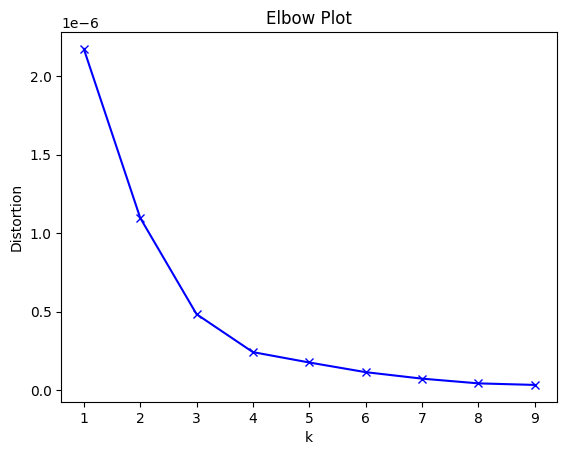

Silhouette Score: 0.6163569945262114
ARI: 0.043701442841287456

Cluster ID: 0
Purity Score: 40.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 5

Cluster ID: 1
Purity Score: 28.57%
Dominant Topic: 8
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 7

Cluster ID: 2
Purity Score: 100.0%
Dominant Topic: 13
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 1

Cluster ID: 3
Purity Score: 50.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 8

Cluster ID: 4
Purity Score: 50.0%
Dominant Topic: 4
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 2

Cluster ID: 5
Purity Score: 100.0%
Dominant Topic: 6
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 6
Purity Score: 25.0%
Dominant Topic: 3
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 4

Cluster ID: 7
Purity Score: 42.86%
Dominant Topic: 14
Number o

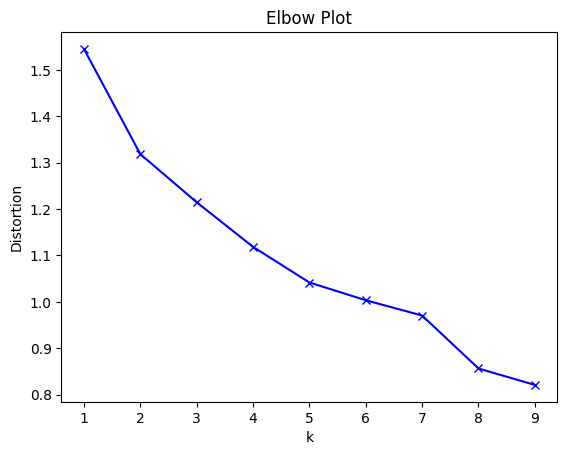

Silhouette Score: 0.20626437664031982
ARI: 0.1030758497664191

Cluster ID: 0
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 4

Cluster ID: 1
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 12

Cluster ID: 2
Purity Score: 50.0%
Dominant Topic: 8
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 4

Cluster ID: 3
Purity Score: 100.0%
Dominant Topic: 1
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 4
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 3
Topic Questions in Cluster: 3

Cluster ID: 5
Purity Score: 21.43%
Dominant Topic: 14
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 28

Cluster ID: 6
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 4

Cluster ID: 7
Purity Score: 100.0%
Dominant Topic: 14
N

In [110]:
tokens_c_data_avg_purity = k_means(10, tokens_c_avg_array, tokens_c_data_embeddings_avgs_list, c_data)
tokens_c_data_all_purity = k_means(10, tokens_c_all_array, tokens_c_data_vectors_df, c_data)

### Tokens CDC_Data

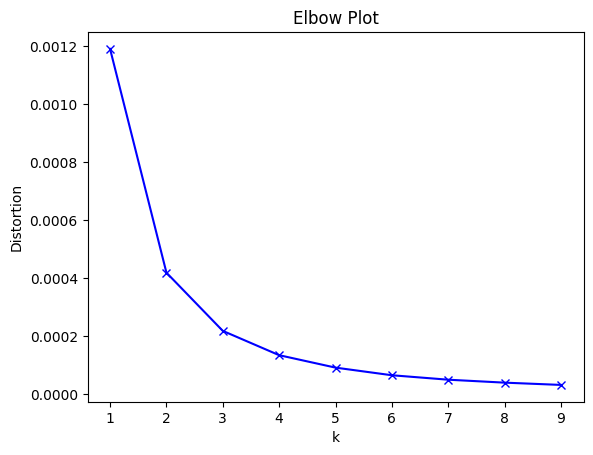

Silhouette Score: 0.5305533503334084
ARI: 0.006958141591652484

Cluster ID: 0
Purity Score: 4.82%
Dominant Topic: 23
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 249

Cluster ID: 1
Purity Score: 7.83%
Dominant Topic: 131
Number of Questions in Dominant Topic: 13
Topic Questions in Cluster: 166

Cluster ID: 2
Purity Score: 8.33%
Dominant Topic: 42
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 192

Cluster ID: 3
Purity Score: 10.0%
Dominant Topic: 8
Number of Questions in Dominant Topic: 8
Topic Questions in Cluster: 80

Cluster ID: 4
Purity Score: 9.57%
Dominant Topic: 136
Number of Questions in Dominant Topic: 11
Topic Questions in Cluster: 115

Cluster ID: 5
Purity Score: 7.31%
Dominant Topic: 63
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 219

Cluster ID: 6
Purity Score: 11.33%
Dominant Topic: 63
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 150

Cluster ID: 7
Purity Score: 12.0%
Domina

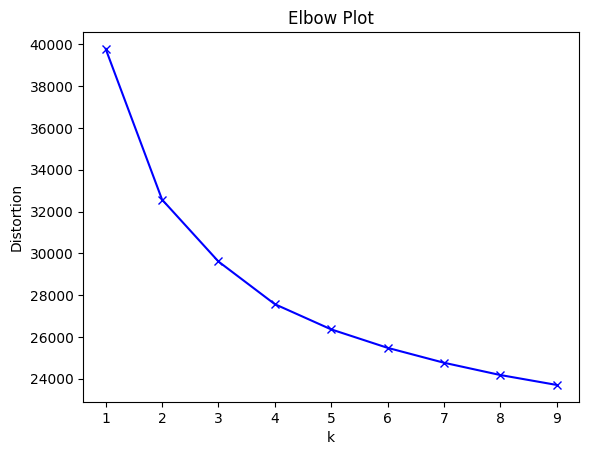

Silhouette Score: 0.08107292652130127
ARI: 0.011306054376075576

Cluster ID: 0
Purity Score: 8.33%
Dominant Topic: 41
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 120

Cluster ID: 1
Purity Score: 6.08%
Dominant Topic: 131
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 263

Cluster ID: 2
Purity Score: 8.3%
Dominant Topic: 63
Number of Questions in Dominant Topic: 19
Topic Questions in Cluster: 229

Cluster ID: 3
Purity Score: 13.08%
Dominant Topic: 63
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 107

Cluster ID: 4
Purity Score: 6.42%
Dominant Topic: 42
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 218

Cluster ID: 5
Purity Score: 8.7%
Dominant Topic: 63
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 115

Cluster ID: 6
Purity Score: 8.06%
Dominant Topic: 23
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 62

Cluster ID: 7
Purity Score: 11.61%
Domina

In [111]:
tokens_cdc_data_avg_purity = k_means(10, tokens_cdc_avg_array, tokens_cdc_data_embeddings_avgs_list, cdc_data)
tokens_cdc_data_all_purity = k_means(10, tokens_cdc_all_array, tokens_cdc_data_vectors_df, cdc_data)

### Tokens Class_Data

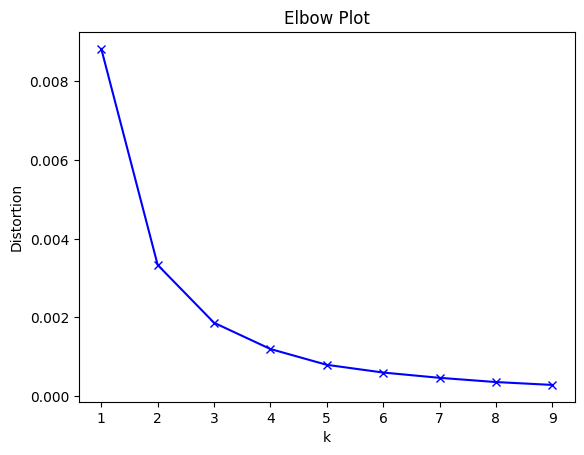

Silhouette Score: 0.5322448967814847
ARI: 0.005723697986598753

Cluster ID: 0
Purity Score: 20.69%
Dominant Topic: 70
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 58

Cluster ID: 1
Purity Score: 5.88%
Dominant Topic: 91
Number of Questions in Dominant Topic: 15
Topic Questions in Cluster: 255

Cluster ID: 2
Purity Score: 8.98%
Dominant Topic: 70
Number of Questions in Dominant Topic: 23
Topic Questions in Cluster: 256

Cluster ID: 3
Purity Score: 12.17%
Dominant Topic: 44
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 115

Cluster ID: 4
Purity Score: 5.35%
Dominant Topic: 147
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 318

Cluster ID: 5
Purity Score: 7.86%
Dominant Topic: 70
Number of Questions in Dominant Topic: 11
Topic Questions in Cluster: 140

Cluster ID: 6
Purity Score: 5.56%
Dominant Topic: 44
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 216

Cluster ID: 7
Purity Score: 25.0%
Domi

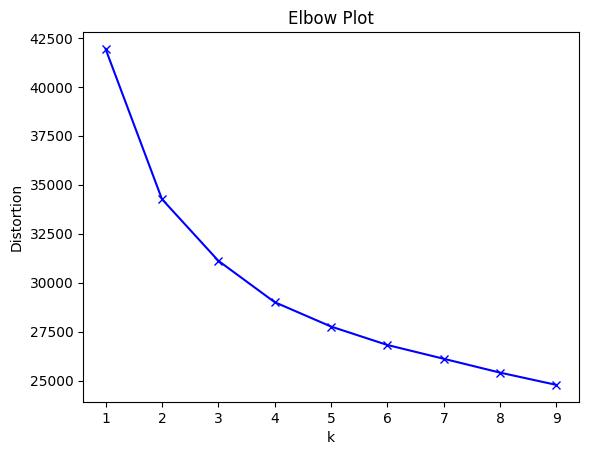

Silhouette Score: 0.07322095334529877
ARI: 0.009799311963484946

Cluster ID: 0
Purity Score: 7.62%
Dominant Topic: 147
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 210

Cluster ID: 1
Purity Score: 12.93%
Dominant Topic: 70
Number of Questions in Dominant Topic: 15
Topic Questions in Cluster: 116

Cluster ID: 2
Purity Score: 6.58%
Dominant Topic: 13
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 76

Cluster ID: 3
Purity Score: 6.52%
Dominant Topic: 105
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 184

Cluster ID: 4
Purity Score: 5.59%
Dominant Topic: 70
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 179

Cluster ID: 5
Purity Score: 10.37%
Dominant Topic: 44
Number of Questions in Dominant Topic: 28
Topic Questions in Cluster: 270

Cluster ID: 6
Purity Score: 8.63%
Dominant Topic: 70
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 139

Cluster ID: 7
Purity Score: 6.82%
Dom

In [112]:
tokens_class_data_avg_purity = k_means(10, tokens_class_avg_array, tokens_classified_embeddings_avgs_list, class_data)
tokens_class_data_all_purity = k_means(10, tokens_class_array, tokens_classified_data_vectors_df, class_data)

## Bigrams Purity Scores

In [113]:
# bigram_c_data_avg_purity = k_means(10, bigram_c_avg_array, bigram_c_data_vectors_df, c_data)
# bigram_c_data_all_purity = k_means(10, bigram_c_all_array, bigram_c_data_vectors_df, c_data)

# bigram_cdc_data_avg_purity = k_means(10, bigram_cdc_avg_array, bigram_cdc_data_vectors_df, cdc_data)
# bigram_cdc_data_all_purity = k_means(10, bigram_cdc_all_array, bigram_cdc_data_vectors_df, cdc_data)

# bigram_class_data_avg_purity = k_means(10, bigram_class_avg_array, bigram_classified_data_vectors_df, class_data)
# bigram_class_data_all_purity = k_means(10, bigram_class_avg_array, bigram_classified_data_vectors_df, class_data)

## Lemma Purity Scores

### Lemma C_Data



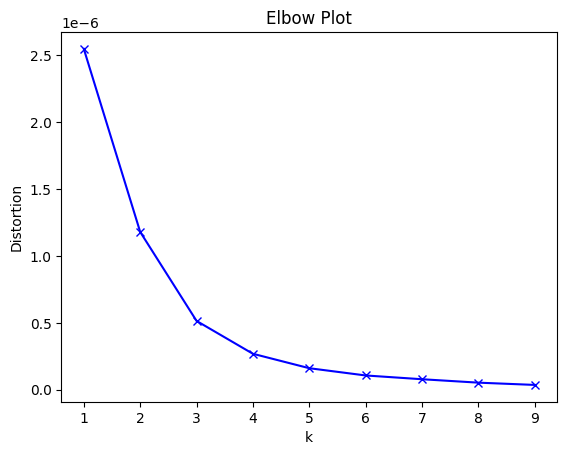

Silhouette Score: 0.5707269082797238
ARI: 0.05216426193118757

Cluster ID: 0
Purity Score: 100.0%
Dominant Topic: 6
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 1
Purity Score: 40.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 15

Cluster ID: 2
Purity Score: 66.67%
Dominant Topic: 11
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 6

Cluster ID: 3
Purity Score: 16.67%
Dominant Topic: 0
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 6

Cluster ID: 4
Purity Score: 33.33%
Dominant Topic: 12
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 3

Cluster ID: 5
Purity Score: 36.36%
Dominant Topic: 14
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 11

Cluster ID: 6
Purity Score: 50.0%
Dominant Topic: 15
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 2

Cluster ID: 7
Purity Score: 100.0%
Dominant Topic: 15
Num

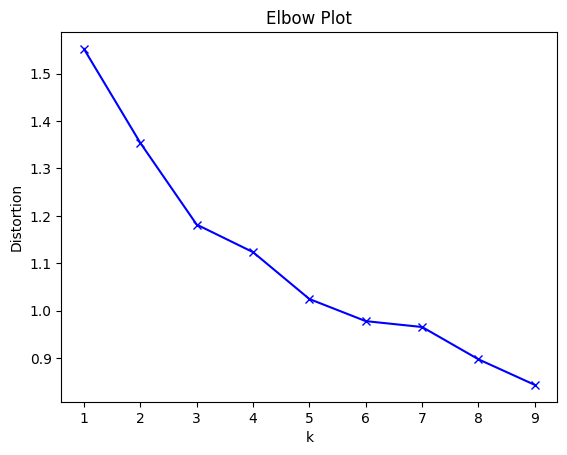

Silhouette Score: 0.2114483267068863
ARI: 0.062072892938496584

Cluster ID: 0
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 3
Topic Questions in Cluster: 3

Cluster ID: 1
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 12

Cluster ID: 2
Purity Score: 66.67%
Dominant Topic: 15
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 3

Cluster ID: 3
Purity Score: 100.0%
Dominant Topic: 1
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 4
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 4

Cluster ID: 5
Purity Score: 20.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 30

Cluster ID: 6
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 1

Cluster ID: 7
Purity Score: 100.0%
Dominant Topic: 14

In [114]:
lemma_c_data_avg_purity = k_means(10, lemma_c_avg_array, lemma_c_data_embeddings_avgs_list, c_data)
lemma_c_data_all_purity = k_means(10, lemma_c_all_array, lemma_c_data_vectors_df, c_data)

### Lemma CDC_Data

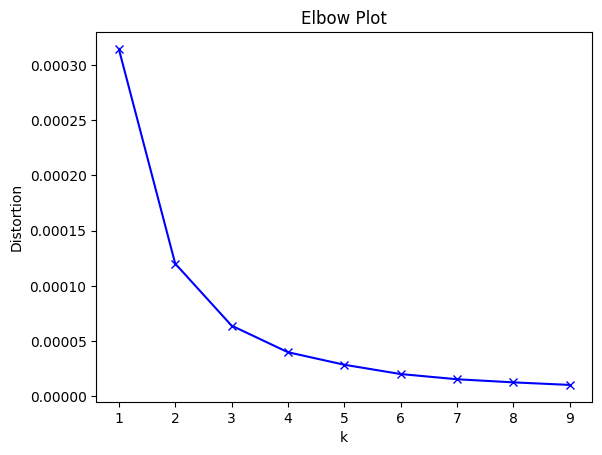

Silhouette Score: 0.528489504706182
ARI: 0.0065005881324584685

Cluster ID: 0
Purity Score: 5.84%
Dominant Topic: 63
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 274

Cluster ID: 1
Purity Score: 9.09%
Dominant Topic: 37
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 110

Cluster ID: 2
Purity Score: 6.62%
Dominant Topic: 8
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 151

Cluster ID: 3
Purity Score: 8.36%
Dominant Topic: 63
Number of Questions in Dominant Topic: 24
Topic Questions in Cluster: 287

Cluster ID: 4
Purity Score: 6.74%
Dominant Topic: 63
Number of Questions in Dominant Topic: 19
Topic Questions in Cluster: 282

Cluster ID: 5
Purity Score: 12.9%
Dominant Topic: 8
Number of Questions in Dominant Topic: 8
Topic Questions in Cluster: 62

Cluster ID: 6
Purity Score: 14.29%
Dominant Topic: 42
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 42

Cluster ID: 7
Purity Score: 7.66%
Dominant To

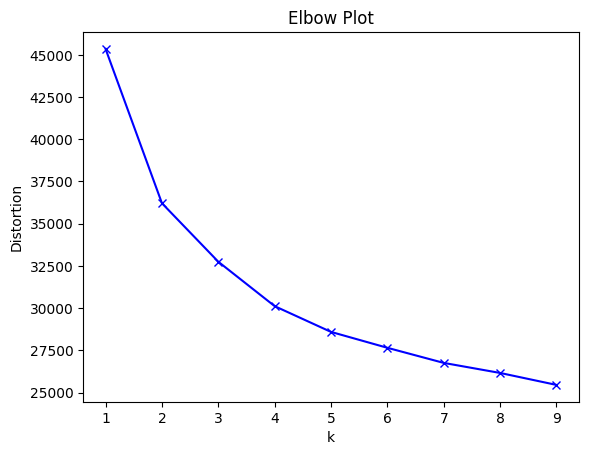

Silhouette Score: 0.09438091516494751
ARI: 0.011000826595534337

Cluster ID: 0
Purity Score: 6.64%
Dominant Topic: 131
Number of Questions in Dominant Topic: 15
Topic Questions in Cluster: 226

Cluster ID: 1
Purity Score: 8.22%
Dominant Topic: 63
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 146

Cluster ID: 2
Purity Score: 12.73%
Dominant Topic: 42
Number of Questions in Dominant Topic: 34
Topic Questions in Cluster: 267

Cluster ID: 3
Purity Score: 4.95%
Dominant Topic: 16
Number of Questions in Dominant Topic: 9
Topic Questions in Cluster: 182

Cluster ID: 4
Purity Score: 6.02%
Dominant Topic: 66
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 166

Cluster ID: 5
Purity Score: 6.6%
Dominant Topic: 63
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 212

Cluster ID: 6
Purity Score: 8.06%
Dominant Topic: 23
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 62

Cluster ID: 7
Purity Score: 13.27%
Domina

In [115]:
lemma_cdc_data_avg_purity = k_means(10, lemma_cdc_avg_array, lemma_cdc_data_embeddings_avgs_list, cdc_data)
lemma_cdc_data_all_purity = k_means(10, lemma_cdc_all_array, lemma_cdc_data_vectors_df, cdc_data)

### Lemma Class_Data

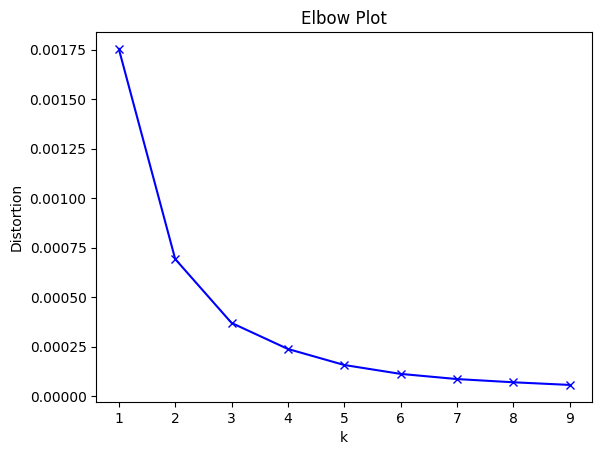

Silhouette Score: 0.5285927825909433
ARI: 0.006694683212680882

Cluster ID: 0
Purity Score: 5.54%
Dominant Topic: 70
Number of Questions in Dominant Topic: 15
Topic Questions in Cluster: 271

Cluster ID: 1
Purity Score: 8.97%
Dominant Topic: 70
Number of Questions in Dominant Topic: 20
Topic Questions in Cluster: 223

Cluster ID: 2
Purity Score: 16.67%
Dominant Topic: 44
Number of Questions in Dominant Topic: 15
Topic Questions in Cluster: 90

Cluster ID: 3
Purity Score: 10.0%
Dominant Topic: 73
Number of Questions in Dominant Topic: 8
Topic Questions in Cluster: 80

Cluster ID: 4
Purity Score: 4.61%
Dominant Topic: 147
Number of Questions in Dominant Topic: 13
Topic Questions in Cluster: 282

Cluster ID: 5
Purity Score: 9.52%
Dominant Topic: 66
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 21

Cluster ID: 6
Purity Score: 6.0%
Dominant Topic: 44
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 200

Cluster ID: 7
Purity Score: 5.85%
Dominant T

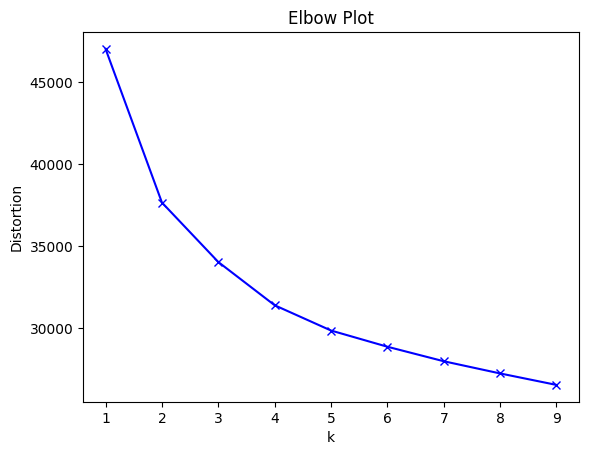

Silhouette Score: 0.09091531485319138
ARI: 0.009698021302949344

Cluster ID: 0
Purity Score: 6.42%
Dominant Topic: 147
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 265

Cluster ID: 1
Purity Score: 5.73%
Dominant Topic: 147
Number of Questions in Dominant Topic: 11
Topic Questions in Cluster: 192

Cluster ID: 2
Purity Score: 14.66%
Dominant Topic: 70
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 116

Cluster ID: 3
Purity Score: 11.38%
Dominant Topic: 44
Number of Questions in Dominant Topic: 33
Topic Questions in Cluster: 290

Cluster ID: 4
Purity Score: 7.23%
Dominant Topic: 70
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 166

Cluster ID: 5
Purity Score: 5.88%
Dominant Topic: 70
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 170

Cluster ID: 6
Purity Score: 6.6%
Dominant Topic: 147
Number of Questions in Dominant Topic: 13
Topic Questions in Cluster: 197

Cluster ID: 7
Purity Score: 6.58%
D

In [116]:
lemma_class_data_avg_purity = k_means(10, lemma_class_avg_array, lemma_classified_data_embeddings_avgs_list, class_data)
lemma_class_data_all_purity = k_means(10, lemma_class_array, lemma_classified_data_vectors_df, class_data)

## Porter Purity Scores

### Porter C_Data

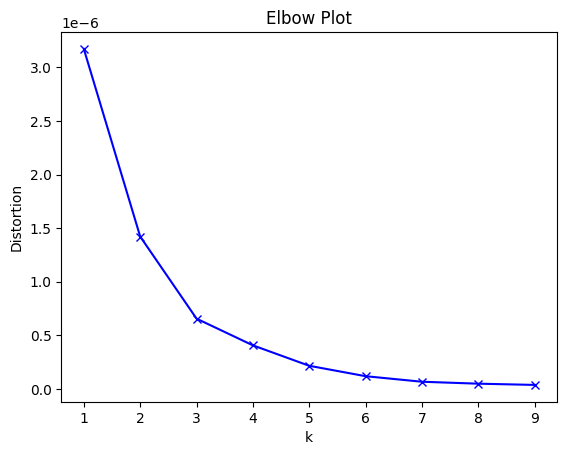

Silhouette Score: 0.590269410602492
ARI: 0.04861282215542305

Cluster ID: 0
Purity Score: 100.0%
Dominant Topic: 6
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 1
Purity Score: 40.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 10

Cluster ID: 2
Purity Score: 33.33%
Dominant Topic: 11
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 3

Cluster ID: 3
Purity Score: 40.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 5

Cluster ID: 4
Purity Score: 71.43%
Dominant Topic: 14
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 7

Cluster ID: 5
Purity Score: 50.0%
Dominant Topic: 13
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 2

Cluster ID: 6
Purity Score: 20.0%
Dominant Topic: 8
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 5

Cluster ID: 7
Purity Score: 28.57%
Dominant Topic: 11
Number 

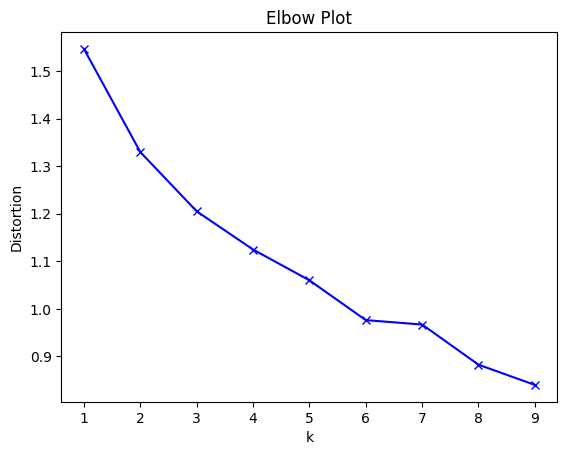

Silhouette Score: 0.18980640172958374
ARI: 0.09147266881028938

Cluster ID: 0
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 4

Cluster ID: 1
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 12

Cluster ID: 2
Purity Score: 66.67%
Dominant Topic: 15
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 3

Cluster ID: 3
Purity Score: 100.0%
Dominant Topic: 1
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 4
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 5

Cluster ID: 5
Purity Score: 20.69%
Dominant Topic: 14
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 29

Cluster ID: 6
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 1

Cluster ID: 7
Purity Score: 100.0%
Dominant Topic: 1

In [117]:
porter_c_data_avg_purity = k_means(10, porter_c_avg_array, porter_c_data_embeddings_avgs_list, c_data)
porter_c_data_all_purity = k_means(10, porter_c_all_array, porter_c_data_vectors_df, c_data)

### Porter CDC_Data

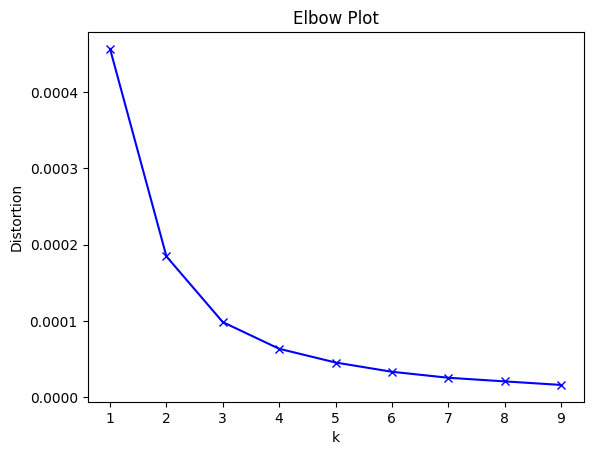

Silhouette Score: 0.5294178197417126
ARI: 0.005301115498655821

Cluster ID: 0
Purity Score: 5.11%
Dominant Topic: 23
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 313

Cluster ID: 1
Purity Score: 9.09%
Dominant Topic: 63
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 187

Cluster ID: 2
Purity Score: 6.99%
Dominant Topic: 42
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 229

Cluster ID: 3
Purity Score: 8.26%
Dominant Topic: 42
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 121

Cluster ID: 4
Purity Score: 14.05%
Dominant Topic: 63
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 121

Cluster ID: 5
Purity Score: 6.52%
Dominant Topic: 63
Number of Questions in Dominant Topic: 18
Topic Questions in Cluster: 276

Cluster ID: 6
Purity Score: 23.08%
Dominant Topic: 42
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 26

Cluster ID: 7
Purity Score: 4.59%
Domina

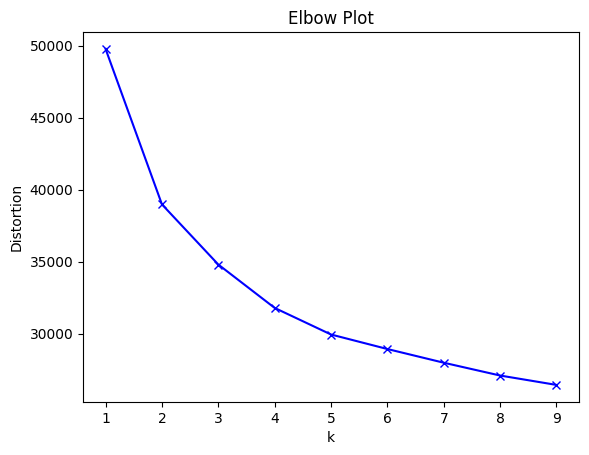

Silhouette Score: 0.10219131410121918
ARI: 0.010618121548120033

Cluster ID: 0
Purity Score: 5.37%
Dominant Topic: 42
Number of Questions in Dominant Topic: 11
Topic Questions in Cluster: 205

Cluster ID: 1
Purity Score: 5.19%
Dominant Topic: 63
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 231

Cluster ID: 2
Purity Score: 10.17%
Dominant Topic: 63
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 118

Cluster ID: 3
Purity Score: 19.23%
Dominant Topic: 17
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 26

Cluster ID: 4
Purity Score: 11.22%
Dominant Topic: 42
Number of Questions in Dominant Topic: 35
Topic Questions in Cluster: 312

Cluster ID: 5
Purity Score: 8.88%
Dominant Topic: 63
Number of Questions in Dominant Topic: 19
Topic Questions in Cluster: 214

Cluster ID: 6
Purity Score: 5.3%
Dominant Topic: 16
Number of Questions in Dominant Topic: 8
Topic Questions in Cluster: 151

Cluster ID: 7
Purity Score: 9.09%
Domina

In [118]:
porter_cdc_data_avg_purity = k_means(10, porter_cdc_avg_array, porter_cdc_data_embeddings_avgs_list, cdc_data)
porter_cdc_data_all_purity = k_means(10, porter_cdc_all_array, porter_cdc_data_vectors_df, cdc_data)

### Porter Class_Data

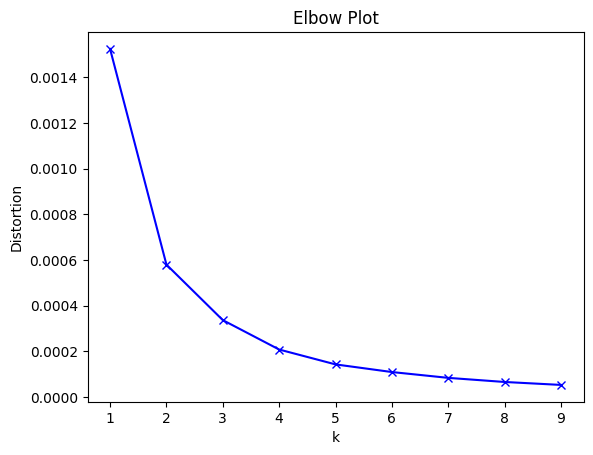

Silhouette Score: 0.5286224550833345
ARI: 0.0064113610056298394

Cluster ID: 0
Purity Score: 15.0%
Dominant Topic: 70
Number of Questions in Dominant Topic: 21
Topic Questions in Cluster: 140

Cluster ID: 1
Purity Score: 4.25%
Dominant Topic: 147
Number of Questions in Dominant Topic: 11
Topic Questions in Cluster: 259

Cluster ID: 2
Purity Score: 6.46%
Dominant Topic: 147
Number of Questions in Dominant Topic: 21
Topic Questions in Cluster: 325

Cluster ID: 3
Purity Score: 13.85%
Dominant Topic: 44
Number of Questions in Dominant Topic: 9
Topic Questions in Cluster: 65

Cluster ID: 4
Purity Score: 14.5%
Dominant Topic: 44
Number of Questions in Dominant Topic: 19
Topic Questions in Cluster: 131

Cluster ID: 5
Purity Score: 6.87%
Dominant Topic: 147
Number of Questions in Dominant Topic: 20
Topic Questions in Cluster: 291

Cluster ID: 6
Purity Score: 16.13%
Dominant Topic: 70
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 31

Cluster ID: 7
Purity Score: 9.87%
Domi

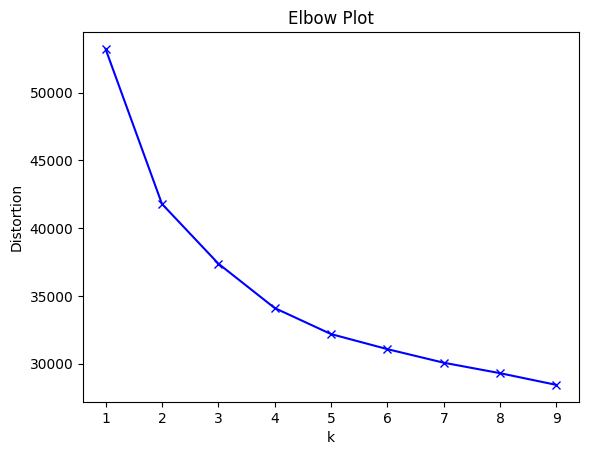

Silhouette Score: 0.09420618414878845
ARI: 0.010155872637700462

Cluster ID: 0
Purity Score: 6.53%
Dominant Topic: 70
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 245

Cluster ID: 1
Purity Score: 7.49%
Dominant Topic: 70
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 187

Cluster ID: 2
Purity Score: 6.48%
Dominant Topic: 147
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 216

Cluster ID: 3
Purity Score: 8.09%
Dominant Topic: 70
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 173

Cluster ID: 4
Purity Score: 7.2%
Dominant Topic: 147
Number of Questions in Dominant Topic: 18
Topic Questions in Cluster: 250

Cluster ID: 5
Purity Score: 19.23%
Dominant Topic: 18
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 26

Cluster ID: 6
Purity Score: 13.5%
Dominant Topic: 44
Number of Questions in Dominant Topic: 32
Topic Questions in Cluster: 237

Cluster ID: 7
Purity Score: 8.06%
Domin

In [119]:
porter_class_data_avg_purity = k_means(10, porter_class_avg_array, porter_classified_data_embeddings_avgs_list, class_data)
porter_class_data_all_purity = k_means(10, porter_class_array, porter_classified_data_vectors_df, class_data)

## Lancaster Purity Scores

### Lancaster C_Data

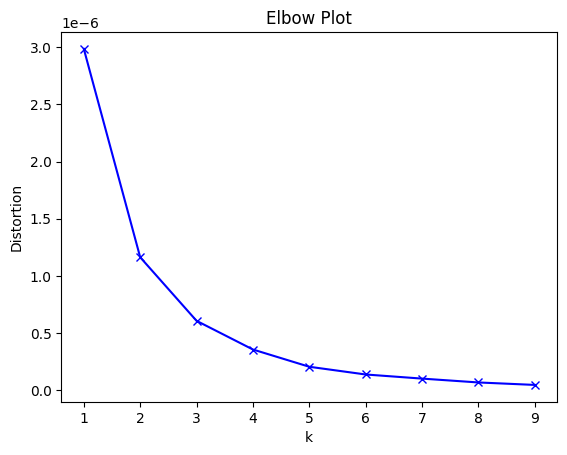

Silhouette Score: 0.5552221754700986
ARI: 0.1358774212200058

Cluster ID: 0
Purity Score: 55.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 11
Topic Questions in Cluster: 20

Cluster ID: 1
Purity Score: 33.33%
Dominant Topic: 0
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 3

Cluster ID: 2
Purity Score: 50.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 10

Cluster ID: 3
Purity Score: 100.0%
Dominant Topic: 2
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 1

Cluster ID: 4
Purity Score: 100.0%
Dominant Topic: 13
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 1

Cluster ID: 5
Purity Score: 40.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 5

Cluster ID: 6
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 3
Topic Questions in Cluster: 3

Cluster ID: 7
Purity Score: 50.0%
Dominant Topic: 14
Numbe

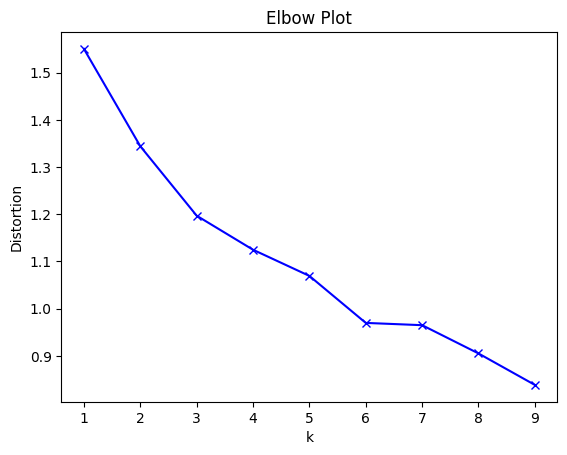

Silhouette Score: 0.19202734529972076
ARI: 0.06702883409945674

Cluster ID: 0
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 4

Cluster ID: 1
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 12

Cluster ID: 2
Purity Score: 66.67%
Dominant Topic: 15
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 3

Cluster ID: 3
Purity Score: 100.0%
Dominant Topic: 1
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 4
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 4

Cluster ID: 5
Purity Score: 20.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 30

Cluster ID: 6
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 1

Cluster ID: 7
Purity Score: 100.0%
Dominant Topic: 14

In [120]:
lancaster_c_data_avg_purity = k_means(10, lancaster_c_avg_array, lancaster_c_data_embeddings_avgs_list, c_data)
lancaster_c_data_all_purity = k_means(10, lancaster_c_all_array, lancaster_c_data_vectors_df, c_data)

### Lancaster CDC_Data

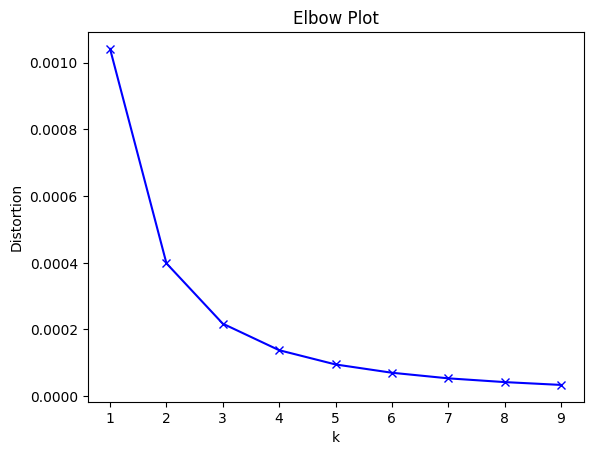

Silhouette Score: 0.5283599641009368
ARI: 0.005356814150803614

Cluster ID: 0
Purity Score: 9.64%
Dominant Topic: 63
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 166

Cluster ID: 1
Purity Score: 4.0%
Dominant Topic: 0
Number of Questions in Dominant Topic: 9
Topic Questions in Cluster: 225

Cluster ID: 2
Purity Score: 12.75%
Dominant Topic: 42
Number of Questions in Dominant Topic: 13
Topic Questions in Cluster: 102

Cluster ID: 3
Purity Score: 6.48%
Dominant Topic: 131
Number of Questions in Dominant Topic: 19
Topic Questions in Cluster: 293

Cluster ID: 4
Purity Score: 20.83%
Dominant Topic: 42
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 24

Cluster ID: 5
Purity Score: 10.0%
Dominant Topic: 21
Number of Questions in Dominant Topic: 3
Topic Questions in Cluster: 30

Cluster ID: 6
Purity Score: 7.38%
Dominant Topic: 131
Number of Questions in Dominant Topic: 20
Topic Questions in Cluster: 271

Cluster ID: 7
Purity Score: 8.93%
Dominant 

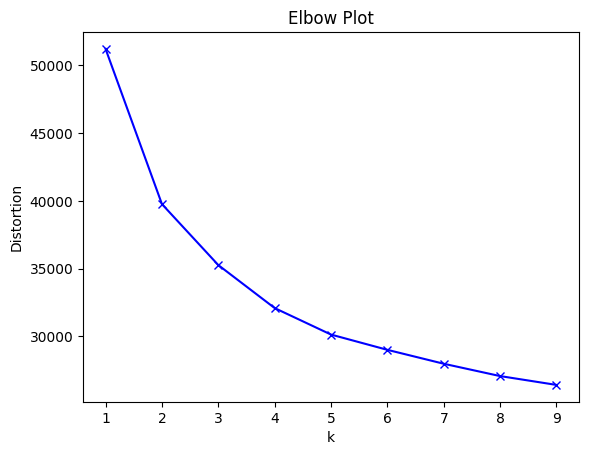

Silhouette Score: 0.10415051132440567
ARI: 0.009323845124752938

Cluster ID: 0
Purity Score: 6.56%
Dominant Topic: 23
Number of Questions in Dominant Topic: 4
Topic Questions in Cluster: 61

Cluster ID: 1
Purity Score: 5.62%
Dominant Topic: 131
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 249

Cluster ID: 2
Purity Score: 11.83%
Dominant Topic: 42
Number of Questions in Dominant Topic: 31
Topic Questions in Cluster: 262

Cluster ID: 3
Purity Score: 8.67%
Dominant Topic: 63
Number of Questions in Dominant Topic: 13
Topic Questions in Cluster: 150

Cluster ID: 4
Purity Score: 7.48%
Dominant Topic: 131
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 214

Cluster ID: 5
Purity Score: 5.83%
Dominant Topic: 66
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 206

Cluster ID: 6
Purity Score: 10.26%
Dominant Topic: 63
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 117

Cluster ID: 7
Purity Score: 20.0%
Dom

In [121]:
lancaster_cdc_data_avg_purity = k_means(10, lancaster_cdc_avg_array, lancaster_cdc_data_embeddings_avgs_list, cdc_data)
lancaster_cdc_data_all_purity = k_means(10, lancaster_cdc_all_array, lancaster_cdc_data_vectors_df, cdc_data)

### Lancaster Class_Data

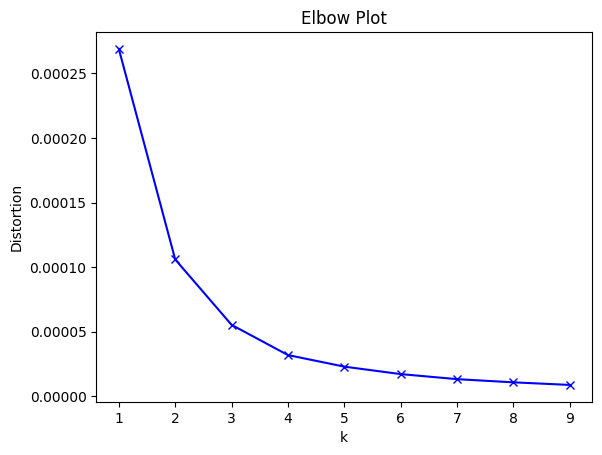

Silhouette Score: 0.5299468470690895
ARI: 0.008766554743482199

Cluster ID: 0
Purity Score: 18.18%
Dominant Topic: 39
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 33

Cluster ID: 1
Purity Score: 5.54%
Dominant Topic: 147
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 307

Cluster ID: 2
Purity Score: 9.31%
Dominant Topic: 44
Number of Questions in Dominant Topic: 19
Topic Questions in Cluster: 204

Cluster ID: 3
Purity Score: 6.45%
Dominant Topic: 147
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 217

Cluster ID: 4
Purity Score: 8.59%
Dominant Topic: 152
Number of Questions in Dominant Topic: 11
Topic Questions in Cluster: 128

Cluster ID: 5
Purity Score: 6.71%
Dominant Topic: 70
Number of Questions in Dominant Topic: 20
Topic Questions in Cluster: 298

Cluster ID: 6
Purity Score: 12.05%
Dominant Topic: 22
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 83

Cluster ID: 7
Purity Score: 11.11%
Dom

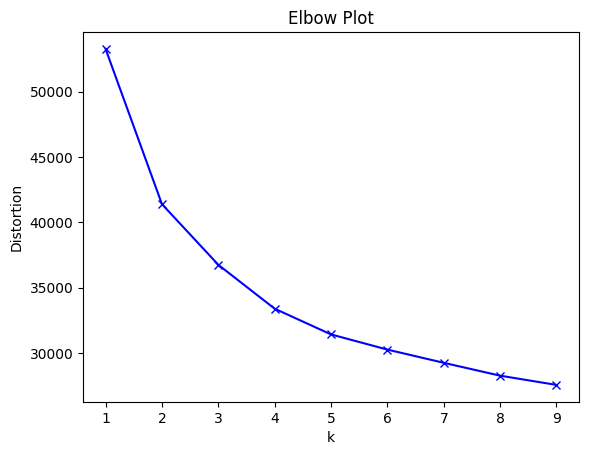

Silhouette Score: 0.09784996509552002
ARI: 0.00979964235216647

Cluster ID: 0
Purity Score: 6.63%
Dominant Topic: 70
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 181

Cluster ID: 1
Purity Score: 6.88%
Dominant Topic: 70
Number of Questions in Dominant Topic: 15
Topic Questions in Cluster: 218

Cluster ID: 2
Purity Score: 7.69%
Dominant Topic: 24
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 65

Cluster ID: 3
Purity Score: 5.85%
Dominant Topic: 147
Number of Questions in Dominant Topic: 12
Topic Questions in Cluster: 205

Cluster ID: 4
Purity Score: 7.82%
Dominant Topic: 70
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 179

Cluster ID: 5
Purity Score: 11.79%
Dominant Topic: 44
Number of Questions in Dominant Topic: 31
Topic Questions in Cluster: 263

Cluster ID: 6
Purity Score: 6.64%
Dominant Topic: 147
Number of Questions in Dominant Topic: 15
Topic Questions in Cluster: 226

Cluster ID: 7
Purity Score: 7.42%
Domin

In [122]:
lancaster_class_data_avg_purity = k_means(10, lancaster_class_avg_array, lancaster_class_data_embeddings_avgs_list, class_data)
lancaster_class_data_all_purity = k_means(10, lancaster_class_array, lancaster_classified_data_vectors_df, class_data)

## Postag Purity Scores

### Postag C_Data

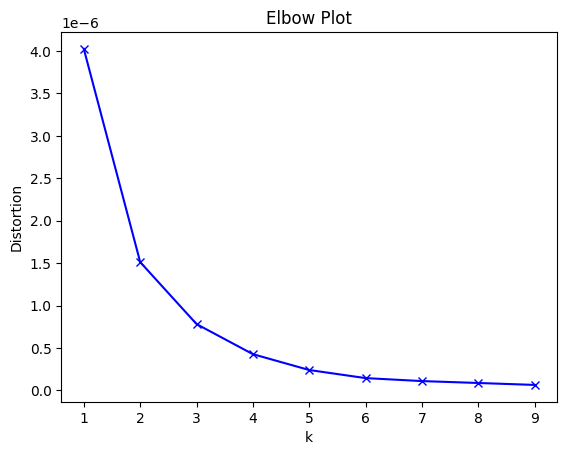

Silhouette Score: 0.5709954437362762
ARI: 0.03719229206322048

Cluster ID: 0
Purity Score: 41.67%
Dominant Topic: 14
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 12

Cluster ID: 1
Purity Score: 100.0%
Dominant Topic: 6
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 2
Purity Score: 66.67%
Dominant Topic: 11
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 3

Cluster ID: 3
Purity Score: 25.0%
Dominant Topic: 13
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 4

Cluster ID: 4
Purity Score: 36.84%
Dominant Topic: 14
Number of Questions in Dominant Topic: 7
Topic Questions in Cluster: 19

Cluster ID: 5
Purity Score: 22.22%
Dominant Topic: 11
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 9

Cluster ID: 6
Purity Score: 50.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 3
Topic Questions in Cluster: 6

Cluster ID: 7
Purity Score: 100.0%
Dominant Topic: 8
Num

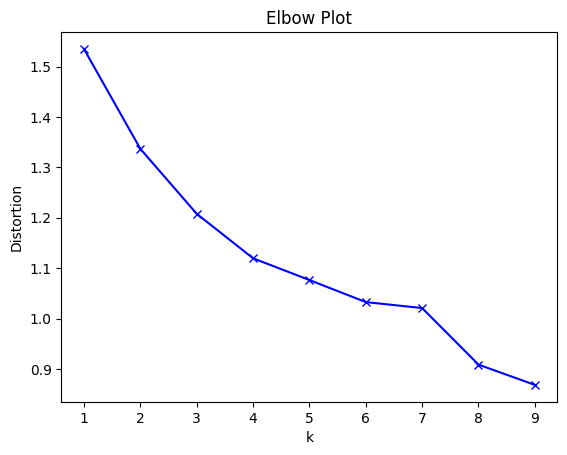

Silhouette Score: 0.14082738757133484
ARI: -0.010472785861739086

Cluster ID: 0
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 6

Cluster ID: 1
Purity Score: 19.35%
Dominant Topic: 14
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 31

Cluster ID: 2
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 3
Topic Questions in Cluster: 3

Cluster ID: 3
Purity Score: 100.0%
Dominant Topic: 1
Number of Questions in Dominant Topic: 2
Topic Questions in Cluster: 2

Cluster ID: 4
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 1

Cluster ID: 5
Purity Score: 100.0%
Dominant Topic: 14
Number of Questions in Dominant Topic: 1
Topic Questions in Cluster: 1

Cluster ID: 6
Purity Score: 100.0%
Dominant Topic: 11
Number of Questions in Dominant Topic: 6
Topic Questions in Cluster: 6

Cluster ID: 7
Purity Score: 100.0%
Dominant Topic: 1

In [123]:
postag_c_data_avg_purity = k_means(10, postag_c_avg_array, postag_c_data_embeddings_avgs_list, c_data)
postag_c_data_all_purity = k_means(10, postag_c_all_array, postag_c_data_vectors_df, c_data)

### Postag CDC_Data

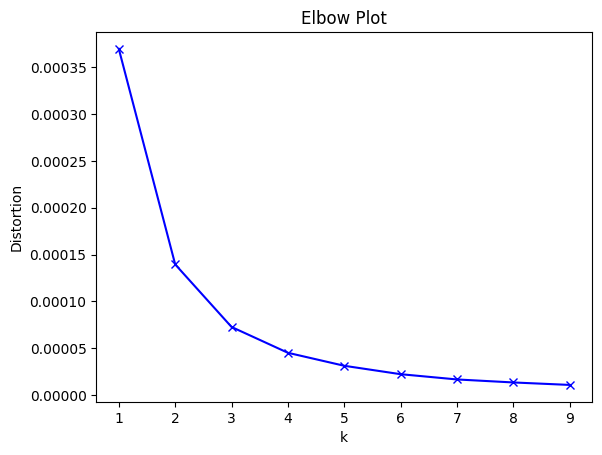

Silhouette Score: 0.5282211326071664
ARI: 0.005376914395517245

Cluster ID: 0
Purity Score: 9.48%
Dominant Topic: 63
Number of Questions in Dominant Topic: 20
Topic Questions in Cluster: 211

Cluster ID: 1
Purity Score: 5.56%
Dominant Topic: 42
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 252

Cluster ID: 2
Purity Score: 11.11%
Dominant Topic: 63
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 45

Cluster ID: 3
Purity Score: 15.38%
Dominant Topic: 42
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 91

Cluster ID: 4
Purity Score: 6.04%
Dominant Topic: 63
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 265

Cluster ID: 5
Purity Score: 9.17%
Dominant Topic: 63
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 109

Cluster ID: 6
Purity Score: 6.16%
Dominant Topic: 131
Number of Questions in Dominant Topic: 18
Topic Questions in Cluster: 292

Cluster ID: 7
Purity Score: 8.25%
Domina

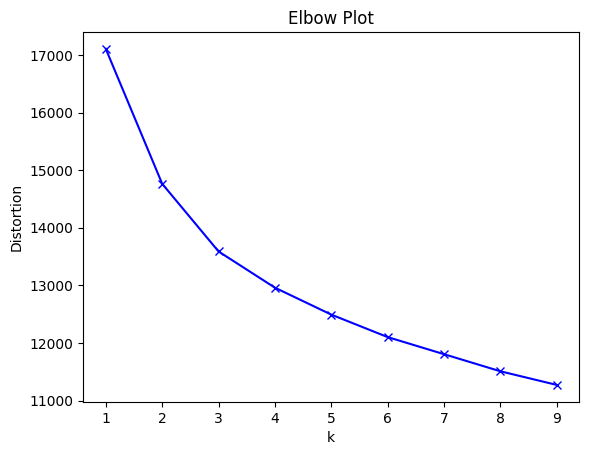

Silhouette Score: 0.06538277864456177
ARI: 0.012683458929391942

Cluster ID: 0
Purity Score: 7.14%
Dominant Topic: 17
Number of Questions in Dominant Topic: 5
Topic Questions in Cluster: 70

Cluster ID: 1
Purity Score: 9.13%
Dominant Topic: 42
Number of Questions in Dominant Topic: 22
Topic Questions in Cluster: 241

Cluster ID: 2
Purity Score: 8.13%
Dominant Topic: 63
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 209

Cluster ID: 3
Purity Score: 14.95%
Dominant Topic: 63
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 107

Cluster ID: 4
Purity Score: 7.3%
Dominant Topic: 131
Number of Questions in Dominant Topic: 13
Topic Questions in Cluster: 178

Cluster ID: 5
Purity Score: 7.14%
Dominant Topic: 63
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 140

Cluster ID: 6
Purity Score: 10.59%
Dominant Topic: 42
Number of Questions in Dominant Topic: 27
Topic Questions in Cluster: 255

Cluster ID: 7
Purity Score: 7.41%
Domin

In [124]:
postag_cdc_data_avg_purity = k_means(10, postag_cdc_avg_array, postag_cdc_data_embeddings_avgs_list, cdc_data)
postag_cdc_data_all_purity = k_means(10, postag_cdc_all_array, postag_cdc_data_vectors_df, cdc_data)

### Postag Class_Data

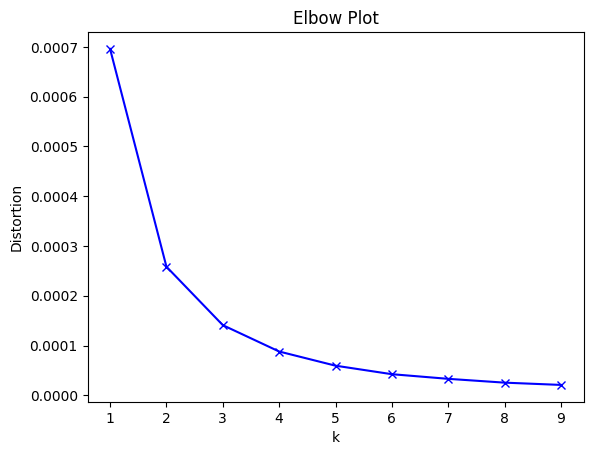

Silhouette Score: 0.5199261628780881
ARI: 0.004352329863154301

Cluster ID: 0
Purity Score: 5.94%
Dominant Topic: 70
Number of Questions in Dominant Topic: 18
Topic Questions in Cluster: 303

Cluster ID: 1
Purity Score: 5.91%
Dominant Topic: 147
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 237

Cluster ID: 2
Purity Score: 7.44%
Dominant Topic: 73
Number of Questions in Dominant Topic: 16
Topic Questions in Cluster: 215

Cluster ID: 3
Purity Score: 8.89%
Dominant Topic: 44
Number of Questions in Dominant Topic: 8
Topic Questions in Cluster: 90

Cluster ID: 4
Purity Score: 8.93%
Dominant Topic: 70
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 112

Cluster ID: 5
Purity Score: 19.61%
Dominant Topic: 70
Number of Questions in Dominant Topic: 10
Topic Questions in Cluster: 51

Cluster ID: 6
Purity Score: 9.88%
Dominant Topic: 44
Number of Questions in Dominant Topic: 17
Topic Questions in Cluster: 172

Cluster ID: 7
Purity Score: 7.17%
Dominan

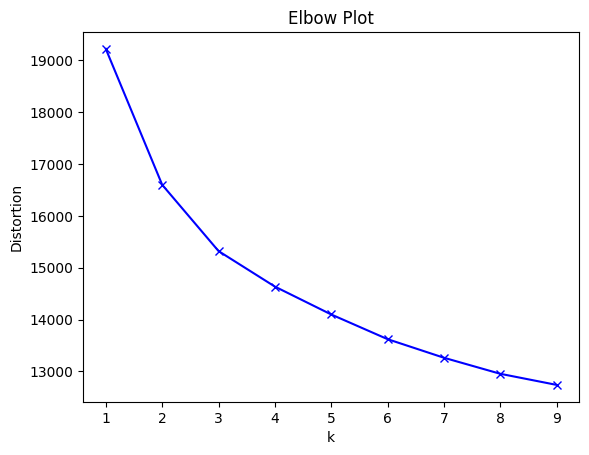

Silhouette Score: 0.06191724166274071
ARI: 0.014212909811358082

Cluster ID: 0
Purity Score: 8.79%
Dominant Topic: 44
Number of Questions in Dominant Topic: 21
Topic Questions in Cluster: 239

Cluster ID: 1
Purity Score: 8.38%
Dominant Topic: 70
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 167

Cluster ID: 2
Purity Score: 13.08%
Dominant Topic: 70
Number of Questions in Dominant Topic: 14
Topic Questions in Cluster: 107

Cluster ID: 3
Purity Score: 13.03%
Dominant Topic: 44
Number of Questions in Dominant Topic: 31
Topic Questions in Cluster: 238

Cluster ID: 4
Purity Score: 5.52%
Dominant Topic: 43
Number of Questions in Dominant Topic: 9
Topic Questions in Cluster: 163

Cluster ID: 5
Purity Score: 6.88%
Dominant Topic: 70
Number of Questions in Dominant Topic: 13
Topic Questions in Cluster: 189

Cluster ID: 6
Purity Score: 8.06%
Dominant Topic: 113
Number of Questions in Dominant Topic: 15
Topic Questions in Cluster: 186

Cluster ID: 7
Purity Score: 6.45%
Dom

In [125]:
postag_class_data_avg_purity = k_means(10, postag_class_avg_array, postag_class_data_embeddings_avgs_list, class_data)
postag_class_data_all_purity = k_means(10, postag_class_array, postag_classified_data_vectors_df, class_data)